# Notebook for Generating Summaries

In [132]:
import os
num_threads = 32
os.environ['NUMEXPR_MAX_THREADS'] = str(num_threads)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)  # rid tqdm depreciation warning

import pandas as pd
import numpy as np
import pickle
import copy
import math
from collections import defaultdict
# from tqdm import tqdm
from tqdm import tqdm_notebook
from sentence_transformers import SentenceTransformer
import ipynb.fs

from sklearn.neighbors import KDTree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM

import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import Hyperband

from multiprocessing import Pool

In [133]:
gpus = tf.config.list_physical_devices('GPU')
print("gpus:")
print(gpus)
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)  # should stop error with LSTMs

gpus:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## Keras NN Model

In [134]:
class NNTuner:
    def __init__(self, save_dir, save_name, input_shape, tuning_iterations=2, max_epochs=15, reduction_factor=3,
                 batch_size=32, force_reload=False, output_dims=1, layer_type="LSTM"):
        """Can save using project_name param, if overwrite false then will reload where it started
        In Tuner Class documentation
        """
        self.input_shape = input_shape
        self.output_dims = output_dims
        self.batch_size = batch_size
        self.layer_type = layer_type.upper()
        self.models = []
        self.distribution_strategy=tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

        self.tuner = Hyperband(self.build_model, 
                          objective='mean_squared_error', 
                          max_epochs=max_epochs,
                          hyperband_iterations=tuning_iterations,
                          factor=reduction_factor,  # keras-tuner default is 3
                          directory=save_dir,
                          project_name=save_name,
                          overwrite=force_reload,
                          tune_new_entries = True,
                          allow_new_entries = True,
                          distribution_strategy=self.distribution_strategy)

        
    def build_model(self, hp):
        model = Sequential()
        # specify input layer to ensure correct input shape
        
        ilayer = None
        if self.layer_type == "LSTM":
            batch_shape = list(self.input_shape)
            batch_shape.insert(0, self.batch_size)
            batch_shape = tuple(batch_shape)
            print("batch_shape : " + str(batch_shape))
            ilayer = tf.keras.Input(batch_shape=batch_shape,
                                name='input_layer')
        elif self.layer_type == "DENSE":
            ilayer = tf.keras.Input(shape=self.input_shape[-1], batch_size=self.batch_size)
        model.add(ilayer)
        
        # add hidden layers
        num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=6)
        for i in range(num_hidden_layers):
            
            units_name = 'hidden_units_' + str(i)
            units = hp.Int(units_name, min_value=32, max_value=2048, step=32)
            print(units_name + ": " + str(units))
            name = 'hidden_layer_' + str(i)
            
            if self.layer_type == "DENSE":
                model.add(Dense(units=units,
                                activation='tanh',
                                name=name))
                
            elif self.layer_type == "LSTM":
                return_sequences = True
                if i == num_hidden_layers - 1:
                    return_sequences = False  # don't return sequences to Dense layer
                    
                model.add(LSTM(units=units,
                              activation='tanh',
                              recurrent_activation='sigmoid',
                              unroll=False,
                              use_bias=True,
                              return_sequences=return_sequences,
                              batch_size=self.batch_size,
                              stateful=False,
                              name=name))
            else:
                raise Exception(str(self.layer_type) + " is not a valid layer type")
            
        # add output layer
        model.add(Dense(units=self.output_dims, 
                        activation='tanh'))
        
        opt = tf.keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=0.000001, max_value=0.001))      
        
        model.compile(optimizer=opt, loss='huber', metrics=['mean_squared_error'])  # add metrics here
        
        self.models.append(model)
        return model
    
    def search(self, batch_generator, best_model_dir):
        """Find optimal model given dataset
        """
        self.tuner.search(x=batch_generator, verbose=1, use_multiprocessing=False, workers=num_threads)
        best_models = self.tuner.get_best_models(num_models=5)
        if best_model_dir is not None:
            for i in range(len(best_models)):
                print("Saving best model number: " + str(i))
                save_path = os.path.join(best_model_dir, str(i))
                best_models[i].save(save_path)
            hyperparams = self.tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model_path = os.path.join(best_model_dir, str(0))
        return best_models[0], hyperparams, best_model_path
    

# from collections import OrderedDict
# from collections import deque

class BatchGenerator(keras.utils.Sequence):
    """Class to load in dataset that is too large to load into memory at once
    
    Do check in class before to make sure all X lists and y lists are same length
    
    https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """
    def __init__(self, X, y, batch_size, num_batches):
        if batch_size is None:
            self.batch_size = 1
        else:
            self.batch_size = batch_size
        self.num_batches = num_batches
        self.X = X
        self.y = y
#         self.shuffle = False  # make sure linear progression through dataset for sake of memory efficiency
        
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.num_batches
    
    def __getitem__(self, idx):
        """Generates one batch of data"""
        inputs = self.load_samples(self.X, idx)
        labels = self.load_samples(self.y, idx)
        return inputs, labels
    
    
    def load_samples(self, path, idx):
        samples = path[idx]
        return samples

## Generating the samples 

In [135]:
from .defs.corpus_loader import PathRetriever, load_embeddings, load_topics, read_df_file_type, save_df_file_type
from .defs.corpus_loader import convert_to_list

In [136]:
def resolve_input_params(path_ret, corpus_names, nested_dirs, col_labels, input_col=None):
    """Helper function to resolve the selection of input params that determine what data to load/generate"""
    # resolve corpus_names
    if corpus_names is None:
        corpus_names = path_ret.get_corpus_names()
        if len(corpus_names) == 0:
            raise Exception("There are no corpuses to load from")
    # resolve col_labels
    if col_labels is None:  # our columns to generate files for
        col_labels = default_col_labels.copy()
        if input_col is not None:
            col_labels.append(input_col)
    # resolve nested_dirs
    if type(nested_dirs) != dict:  # if output gets passed through again
        nested_dict = {}
        for corpus_name in corpus_names:  # get the nested dir for each corpus name
            nested_dict[corpus_name] = path_ret.get_nested_dirs(corpus_name, "embeddings")
            if nested_dirs is not None:
                # add only selected nested_dirs for this corpus_name
                nested_dict[corpus_name] = [x for x in nested_dict[corpus_name] if x in nested_dirs]
        nested_dirs = nested_dict
    # make sure there is at least one entry in nested_dict
    empty_dirs = [len(x) == 0 for x in nested_dirs.values()]  # get if empty for each item
    if all(empty_dirs):
        raise Exception("There are no nested_dirs matching the selection")
    return corpus_names, nested_dirs, col_labels

def corpus_name_topic_ids(path_retriever, corpus_name):
    topic_path = path_retriever.get_topic_path(corpus_name, verbose=False)
    topic_df = load_topics(topic_path, verbose=False)
    topic_ids = list(topic_df['id'].unique())
    return topic_ids

def find_combinations(path_df, corpus_names, nested_dirs, col_labels, add_topics=False, col_labels_as_list=False,
                      as_tuples=True, force_reload=False, path_retriever=None, batch_size=None, file_type=None,
                     exists_only=False):
    """Find the combinations that have not been generated/trained already in path_df
    
    Tuple ordering: (corpus_name, nested_dir, col_label/[col_labels], **topic_id**)
    """
    if exists_only:
        path_df = path_df[path_df['exists'] == True]  # checking of path_df is only concerned with existing files
    if batch_size is not None:
        path_df = path_df[path_df['batch_size'] == batch_size]
    if file_type is not None:
        path_df = path_df[path_df['file_type'] == file_type]
    topic_ids = {}
    if add_topics:  # find topic_ids for each corpus
        for corpus_name in corpus_names:
            if path_retriever is not None:
                topic_ids[corpus_name] = corpus_name_topic_ids(path_retriever, corpus_name)
            else:
                raise Exception("If add_topics is True then path_retriever must be set to an instance of PathRetriever")
    # get possible combinations
    combinations = []
    for corpus_name in corpus_names:
        for nested_dir in nested_dirs[corpus_name]:
            combo_path = path_df[(path_df['corpus_name'] == corpus_name)
                                    & (path_df['nested_dir'] == nested_dir)]
            combo = [corpus_name, nested_dir]
            if add_topics:  # create permutations with topic_ids
                topic_combo_dict = defaultdict(list)
                for label in col_labels:
                    for topic_id in topic_ids[corpus_name]:  # check if label exists for topic_id
                        topic_path = combo_path[(combo_path['col_label'] == label)
                                               & (combo_path['topic_id'] == topic_id)]
                        if len(topic_path) == 0 or force_reload:
                            topic_combo_dict[topic_id].append(label)
                topic_combos = []
                for topic_id, labels in topic_combo_dict.items():
                    topic_combos = []
                    if col_labels_as_list:  # add single tuple with all missing col_labels for topic_id
                        topic_combo = copy.deepcopy(combo)
                        topic_combo.append(labels)
                        topic_combo.append(topic_id)
                        topic_combos.append(topic_combo)
                    else:
                        for label in labels:  # add a tuple for each missing col_label for topic_id
                            topic_combo = copy.deepcopy(combo)
                            topic_combo.append(topic_id)
                            topic_combos.append(topic_combo)
                    combinations.extend(topic_combos)
            else:  # create permutations with col_labels only
                label_combos = []
                add_labels = None
                if not force_reload:  # find which col_labels don't exist already
                    exist_labels = list(combo_path['col_label'].unique())
                    add_labels = [x for x in col_labels if x not in exist_labels]
                else:
                    add_labels = copy.deepcopy(col_labels)  # force_reload add all labels
                if col_labels_as_list:  # add single tuple
                    label_combo = copy.deepcopy(combo)
                    label_combo.append(add_labels)
                    label_combos.append(label_combo)
                else:
                    for add_label in add_labels:  # add tuple for each col_label
                        label_combo = copy.deepcopy(combo)
                        label_combo.append(add_label)
                        label_combos.append(label_combo)
                combinations.extend(label_combos)
                
    if as_tuples:
        combinations = [tuple(x) for x in combinations]
    return combinations

In [137]:
class MemmapGenerator:
    def __init__(self, proj_dir='/nfs/proj-repo/AAARG-dissertation'):
        self.proj_dir = proj_dir
        self.default_file_type = ".hdf"
        self.path_ret = PathRetriever(proj_dir)
        self.path_df_cols = ['corpus_name', 'nested_dir', 'col_label', 'path', 'dtype', 'vector_len', 
                             'total_nums', 'offset_step', 'topic_ids', 'complete']
        self.dataset_dir = self.path_ret.path_handler.dataset_dir
        self.sample_dir = os.path.join(self.dataset_dir, "samples")
        self.path_df_path = os.path.join(self.dataset_dir, "memmap_paths.hdf")
        self.path_df = self.load_path_df()
        self.order = 'C'
        
        
    def create_maps(self, corpus_name, nested_dir, col_labels, topic_ids, verbose=True, force_reload=False):
        # check if already completed
        path_slice = self.slice_path_df(corpus_name, nested_dir, topic_ids)
        emb_paths = self.path_ret.get_embedding_paths(corpus_name, nested_dir, 
                                    file_type=self.default_file_type, verbose=False, 
                                    return_dir_path=False, topic_ids=topic_ids)
        emb_paths = list(emb_paths['path'])
        # load partial information on maps that need completed
        meta_dict = self.create_meta_dict(path_slice, corpus_name, nested_dir, col_labels, 
                                          self.topic_ids_str(topic_ids), force_reload=force_reload)
        
        if len(meta_dict) > 0:
            if verbose:
                print("Creating memmaps for " + str(", ".join(col_labels)) + "\nwith topics: " + str(topic_ids))
                if force_reload:
                    print("force_reload set to True")
            for emb_path in tqdm_notebook(emb_paths):
                # get the cols that haven't been loaded for this path
                # scrape data from dataframe
                label_data = self.scrape_col_data(emb_path, meta_dict.keys())
                # add data to memmap
                for col_label, data in label_data.items():
                    col_dict = meta_dict[col_label]
                    if not col_dict['initialised']:
                        col_dict['dtype'] = data.dtype
                        ndim = data.ndim
                        if ndim == 1:  # 1d
                            col_dict['vector_len'] = 1
                        elif ndim == 2:  # 2d
                            col_dict['vector_len'] = data.shape[1]
                        else:
                            raise Exception("Too many dimensions: " + str(data.shape))
                        col_dict['offset_step'] = data.dtype.itemsize
                        col_dict['initialised'] = True
                        
                        
                    # load meta_dict vars, save hashing time
                    total_nums = col_dict['total_nums']
                    offset_step = col_dict['offset_step']
                    path = col_dict['path']
                    dtype = col_dict['dtype']

                    # add data to map
                    flat = data.ravel()
                    num_to_add = len(flat)
                    
                    memmap = None
                    if total_nums != 0:  # write to existing file 
                        memmap = np.memmap(path, dtype=dtype, mode='r+', offset=0, 
                                       order=self.order, shape=(total_nums + num_to_add,))
                    else:  # create new file on first iteration
                        memmap = np.memmap(path, dtype=dtype, mode='w+', offset=0, 
                                       order=self.order, shape=(num_to_add,))
                    
                    memmap[total_nums:total_nums+num_to_add] = flat[:]
                    if not np.array_equal(memmap[total_nums:total_nums+num_to_add], flat):
                        print("memmap: " + str(memmap[total_nums:total_nums+num_to_add]))
                        print("flat: " + str(flat))
                        raise Exception("Memmap and flat not equal")
                    
                    memmap.flush()

                    # update fields
                    col_dict['total_nums'] += num_to_add
                    
            for col_label, meta in meta_dict.items():
                self.update_path_df_entry(meta['path'], col_label, meta['dtype'], meta['vector_len'],
                         meta['offset_step'], meta['total_nums'])

            if verbose:
                print(display(path_slice))
            print("Completed creating memmaps")
        else:
            print("Already loaded " + str(col_labels))
            
    def update_path_df_entry(self, path, col_label, dtype, vector_len, offset_step, total_nums):
        mask = (self.path_df['path'] == path) & (self.path_df['col_label'] == col_label)
        change_cols = ['dtype', 'vector_len', 'offset_step', 'total_nums', 'complete']
        self.path_df.loc[mask, change_cols] = dtype, vector_len, offset_step, total_nums, True
        self.save_path_df()
        
            
    def add_path_df_entry(self, corpus_name, nested_dir, col_label, path, topic_ids, return_row_dict=False):
        row = {'corpus_name':corpus_name, 'nested_dir':nested_dir, 'col_label':col_label, 
               'path':path, 'dtype':None, 'vector_len':np.nan, 'total_nums':0, 
               'offset_step':0, 'topic_ids':topic_ids, 'complete':False}
        self.path_df = self.path_df.append(row, ignore_index=True)
        self.save_path_df()
        if return_row_dict:
            return row
        
    def create_meta_dict(self, path_slice, corpus_name, nested_dir, col_labels, topic_ids,
                        force_reload=False):
        meta_dict = {}
        for col_label in col_labels:
            col_slice = path_slice[path_slice['col_label'] == col_label]
            if len(col_slice) > 0:
                if len(col_slice) == 1:
                    complete = list(col_slice['complete'])[0]
                    if not complete or force_reload:
                        # add previous values
                        col_slice = col_slice.to_dict(orient='list')
                        col_slice['path'][0]
                        row_dict = {"dtype":col_slice['dtype'][0], "path":col_slice['path'][0], 
                                    "vector_len":col_slice['vector_len'][0], 
                                    "offset_step":col_slice['offset_step'][0], "total_nums":0, # set to 0 to restart
                                    "initialised":False, "completed":False}  
                        meta_dict[col_label] = row_dict
                else:
                    print(display(col_slice))
                    raise Exception("Multiple entries in path_df")
            else:
                # add to path df
                row_dict = self.add_path_df_entry(corpus_name, nested_dir, col_label,
                                                 self.generate_new_map_path(col_label),
                                                 topic_ids, return_row_dict=True)
                row_dict['initialised'] = False
                meta_dict[col_label] = row_dict
        return meta_dict
        
    def load_memmap(self, corpus_name, nested_dir, topic_ids, col_label, batch_size=None, timesteps=None,
                   return_input_shape=False):
        path_slice = self.slice_path_df(corpus_name, nested_dir, topic_ids)
        col_slice = path_slice[path_slice['col_label'] == col_label]
        if len(col_slice) == 1:
            col_dict = col_slice.to_dict(orient='list')
            dtype = col_dict['dtype'][0]
            vector_len = int(col_dict['vector_len'][0])
            total_nums = int(col_dict['total_nums'][0])
            path = col_dict['path'][0]
            
            # get shape of data
            shape = [vector_len]  # base shape
            input_shape = [vector_len]  # exclude batching info / num_items
            num_items = int(total_nums / vector_len)  # num vectors
            if batch_size is not None:
                if timesteps is not None:  # timesteps only available when batches selected
                    timesteps_dims = [timesteps]
                    shape.extend(timesteps_dims)
                    input_shape.extend(timesteps_dims)
                    num_items = math.floor(num_items / timesteps)  # num timesteps
                
                shape.append(batch_size)
                input_shape.append(batch_size)
                num_items = math.floor(num_items / batch_size)  # num batches
                
            shape.append(num_items)  # append last (either num batches or num_vectors)
            total_nums_from_shape = np.product(shape)
            print("total_nums / from shape: " + str(total_nums) + " / " + str(total_nums_from_shape))
            shape.reverse()  # correct order for shape
            input_shape.reverse()
            input_shape = tuple(input_shape)
            shape = tuple(shape)
            
            memmap = np.memmap(path, dtype=dtype, mode='r', shape=shape, order=self.order)
            
            if return_input_shape:
                return memmap, input_shape
            return memmap
        else:
            print(display(path_slice))
            raise Exception(str(len(path_slice)) + " entries for ")
    
    def slice_path_df(self, corpus_name, nested_dir, topic_ids):
        topic_id_str = topic_ids
        if type(topic_id_str) != str:
            topic_id_str = self.topic_ids_str(topic_ids)
            
        mask = (self.path_df['corpus_name'] == corpus_name) & (self.path_df['nested_dir'] == nested_dir) & (self.path_df['topic_ids'] == topic_id_str)
        path_slice = self.path_df.loc[mask]
        return path_slice
        
    def topic_ids_str(self, topic_ids):
        if type(topic_ids) != str:
            sort = sorted(topic_ids)
            sort = [str(x) for x in sort]
            string = ",".join(sort)
            return string
        else:
            raise Exception(str(topic_ids) + " is already type str")
        
    def save_path_df(self):
        save_df_file_type(self.path_df, self.path_df_path, verbose=False)
                
    def load_path_df(self):
        if os.path.exists(self.path_df_path):
            path_df = read_df_file_type(self.path_df_path, verbose=True)
        else:
            path_df = pd.DataFrame(columns=self.path_df_cols)
            print("memmap path df created from scratch")
        return path_df
        
    def incompleted_col_labels(self, path_slice, col_labels):
        incompleted = []
        for col_label in col_labels:
            col_slice = path_slice[path_slice['col_label'] == col_label]
            if len(col_slice) > 0:
                if len(col_slice) == 1:
                    complete = list(col_slice['complete'])[0]
                    if not complete:
                        incompleted.append(col_label)
                else:
                    print(display(col_slice))
                    raise Exception("Multiple entries in path_df")
            else:
                incompleted.append(col_label)
        return incompleted
            
    def generate_new_map_path(self, col_label):
        # putting topic_ids in filename too long, use count instead
        count = len(self.path_df)
        base = str(count) + "_" + str(col_label)
        if not os.path.exists(self.sample_dir):
            os.makedirs(self.sample_dir)
        mappath = os.path.join(self.sample_dir, base + ".memmap")
        return mappath          
            
    def scrape_col_data(self, emb_path, col_labels):
        # setup return variables
        labels = {}
        emb_df = load_embeddings(emb_path, verbose=False)
        for col_label in col_labels:
            if col_label not in emb_df.columns:
                raise ValueError("Target label " + str(col_label) + " is not in file at " + str(emb_path))
            # collect label values from df
            labs = np.array(list(emb_df[col_label]))
            labels[col_label] = labs
        return labels
        

In [171]:
class ModelPathHandler:
    def __init__(self, proj_dir='/nfs/proj-repo/AAARG-dissertation', base_dir_name="tuning_models",
                verbose=True):
        self.proj_dir = proj_dir
        self.base_dir_name = base_dir_name
        self.model_dir_path = os.path.join(self.proj_dir, self.base_dir_name)
        self.df_name = "nn_path_df.hdf"
        self.df_path = os.path.join(self.model_dir_path, self.df_name)
        self.df_cols = ["corpus_name", "nested_dir", "X_col", "y_col", "tuner_dir", 
                                "tuner_name", "best_hyperparams", "batch_size", "best_model_path",
                               "input_param_text_path", "redundancy_threshold", "layer_type"]
        self.verbose = verbose
        self.df = self.load_df(verbose=verbose)
        
    def load_df(self, verbose=True):
        if os.path.exists(self.df_path):
            df = read_df_file_type(self.df_path, verbose=verbose)
        else:
            df = pd.DataFrame(columns=self.df_cols)
            if verbose:
                print("model path df created from scratch")
        return df
    
    def save_df(self, verbose=False):
        save_df_file_type(self.df, self.df_path, verbose=verbose)
    
    def add_path(self, corpus_name, nested_dir, X_col, y_col, tuner_dir, tuner_name, batch_size, 
                 input_param_text_path, layer_type, verbose=True):
        # check if exists in dataframe
        df = self.df
        mask = self.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size, layer_type)
        exist_slice = df.loc[mask]
        if len(exist_slice) == 0:
            print("Appending new row to model path df")
            row = {"corpus_name":corpus_name, "nested_dir":nested_dir, "X_col":X_col,
                  "y_col":y_col, "tuner_dir":tuner_dir, "tuner_name":tuner_name,
                  "batch_size":batch_size,
                  "input_param_text_path":input_param_text_path, 
                  "layer_type":layer_type.upper()}
            self.df = self.df.append(row, ignore_index=True)
        # save new entry
        self.save_df(verbose=verbose)
        
    def generate_nn_save_path(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type, 
                              create_dir=True):
        col_dir = str(layer_type) + "_" + str(X_col) + "_" + str(y_col) + "_" + str(int(batch_size))
        dir_list = [self.model_dir_path, corpus_name, nested_dir, col_dir]
        # combine directories to form path of subdirectories, create dirs if necessary
        dir_path = None
        for cur_dir in dir_list:
            if dir_path is None:  # first iteration
                dir_path = dir_list[0]
            else:
                dir_path = os.path.join(dir_path, cur_dir)
            if not os.path.exists(dir_path) and create_dir:
                os.makedirs(dir_path)
        # generate name
        save_name = "tuner_proj"
        return dir_path, save_name
        
    def update_tuner_instance_col(self, update_col, update_val, corpus_name, nested_dir, X_col, y_col, 
                                  batch_size, layer_type, verbose=True):
        """Update a column value on a row/tuner instance in the path df"""
        mask = self.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size, layer_type)
#         target_row = self.df.loc[mask]
#         target_row[update_col] = update_val
        target_row_idx = self.df.index[mask].tolist()
        if len(target_row_idx) == 1:
            self.df.iat[int(target_row_idx[0]), self.df.columns.get_loc(update_col)] = update_val
        else:
            raise Exception("There are " + str(len(target_row_idx)) + " entries in model path df with given values")
        self.save_df(verbose=verbose)
        
    def create_df_mask(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type):
        layer_type = layer_type.upper()
        mask = (self.df['corpus_name']==corpus_name)&(self.df['nested_dir']==nested_dir)&(self.df['X_col']==X_col)&(self.df['y_col']==y_col)&(self.df['batch_size']==batch_size)&(self.df['layer_type']==layer_type)
        return mask
        
    def load_best_model(self, corpus_name, nested_dir, X_col, y_col, batch_size, layer_type):
        mask = self.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size)
        tuner_instance = self.df.loc[mask]
        best_model_path = list(tuner_instance['best_model_path'])[0]
        model = tf.keras.models.load_model(best_model_path)
        return model
        

In [172]:
from time import gmtime, strftime

class NNTrainer:
    def __init__(self, proj_dir='/nfs/proj-repo/AAARG-dissertation', nn_base_save_dir_name=None):
        self.proj_dir = proj_dir
        self.model_path_handler = ModelPathHandler(proj_dir=proj_dir)
    
    def train(self, corpus_name, nested_dir, topic_ids, X_col, y_col, layer_type, tuning_iterations=5, max_epochs=15,
              reduction_factor=3, batch_size=32, force_reload=False, verbose=True):
        
        if verbose:
            if force_reload:
                print("FORCE RELOAD IS SET TO TRUE")
            print(display(self.model_path_handler.df))
            print("")
        
        # generate data
        mmap_gen = MemmapGenerator(self.proj_dir)
        mmap_gen.create_maps(corpus_name, nested_dir, [X_col, y_col], topic_ids, verbose=verbose,
                                         force_reload=False)  # setting to False for debug
        
        
        timesteps = None
        if layer_type == "LSTM":
            timesteps = 64

        # generate readable X input that can be loaded from disk
        X_map, input_shape = mmap_gen.load_memmap(corpus_name, nested_dir, topic_ids, X_col, 
                                                  batch_size=batch_size, timesteps=timesteps,
                                                  return_input_shape=True)
        
        
        
        # generate readable y output that can be loaded from disk
        y_map = mmap_gen.load_memmap(corpus_name, nested_dir, topic_ids, y_col, batch_size=batch_size,
                                           return_input_shape=False)
        

        # create a generator to feed NN samples/batches
        num_batches = X_map.shape[0]
        print("X_map shape:" + str(X_map.shape))
        print("input_shape: " + str(input_shape))
        batch_generator = BatchGenerator(X_map, y_map, batch_size, num_batches)

        # create paths to save NN tuning files to
        tuner_dir, tuner_name = self.model_path_handler.generate_nn_save_path(corpus_name, nested_dir, X_col, 
                                    y_col, batch_size, layer_type, create_dir=True)
        
        
        # Log params in text file
        trials_in_iter = max_epochs * (math.log(max_epochs, reduction_factor) ** 2)
        cur_time = self.get_cur_time()
        param_str = "corpus_name: " + str(corpus_name) + "\n"
        param_str += "nested_dir: " + str(nested_dir) + "\n"
        param_str += "X_input: " + str(X_col) + "\n"
        param_str += "y_labels: " + str(y_col) + "\n"
        param_str += "batch_size: " + str(batch_size) + "\n"
        param_str += "train_topics: " + str(train_topics) + "\n"
        param_str += "max_epochs: " + str(max_epochs) + "\n"
        param_str += "tuning_iterations: " + str(tuning_iterations) + "\n"
        param_str += "reduction_factor: " + str(reduction_factor) + "\n"
        param_str += "estimated trials per iteration: " + str(trials_in_iter) + "\n"
        param_str += "total estimated trials: " + str(trials_in_iter * tuning_iterations) + "\n"
        param_str += "Started at: " + str(cur_time) + "\n"
        input_param_text_path = os.path.join(tuner_dir, "parameter_details.txt")  # save with NN
        if not os.path.exists(input_param_text_path) or force_reload:
#         if not os.path.exists(input_param_text_path) or True:
            with open(input_param_text_path, "w") as param_file:
                param_file.write(param_str)
        print(param_str)
        
        # add new nn_path_df entry
        self.model_path_handler.add_path(corpus_name, nested_dir, X_col, y_col, tuner_dir, 
                                         tuner_name, batch_size, input_param_text_path, 
                                         layer_type, verbose=verbose)
        
        # generate optimised neural network
        tuner = NNTuner(tuner_dir, tuner_name, input_shape, tuning_iterations=tuning_iterations, 
                        max_epochs=max_epochs, reduction_factor=reduction_factor, force_reload=force_reload, 
                        batch_size=batch_size, layer_type=layer_type)
        
#         # debug get model
#         debug_model = tuner.tuner.get_best_models(num_models=1)[0]
#         debug_path = '/nfs/proj-repo/debug_model'
#         if not os.path.exists(debug_path):
#             os.makedirs(debug_path)
#         debug_model.save(debug_path)
#         raise Exception("Saved debug model")

        best_model_dir = os.path.join(tuner_dir, "best_models")
        best_model, best_hyperparams, best_model_path = tuner.search(batch_generator, best_model_dir)
        
        best_hyperparams = best_hyperparams.values  # convert to dict form
        print("best_hyperparams: " + str(best_hyperparams))
        
        # update best_hyperparams and best_model_path results in path df
        self.model_path_handler.update_tuner_instance_col("best_hyperparams", best_hyperparams, corpus_name, nested_dir, X_col, 
                                       y_col, batch_size, layer_type, verbose=True)
        
        self.model_path_handler.update_tuner_instance_col("best_model_path", best_model_path, corpus_name, nested_dir, X_col, 
                                       y_col, batch_size, layer_type, verbose=True)
        
        
        # add time stamp to param file when finished
        cur_time = self.get_cur_time()
        end_msg = "Ended at: " + str(cur_time) + "\n"
        with open(input_param_text_path, "a") as param_file:
            param_file.write(end_msg)
            
        if verbose:
            print(display(self.model_path_handler.df))
        
        print("Finished tuning neural network")
    
    def get_cur_time(self):
        cur_time = strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime())
        return cur_time

In [140]:
# corpus_name = "mine-trects-kba2014-filtered"
# train_topics = np.arange(11, 47).tolist()  # 11 - 46
# # nested_dirs = ["stsb-roberta-base", "distilbert-base-nli-stsb-mean-tokens"]
# nested_dirs = ["stsb-roberta-base"]
# X_col = "embedding"
# y_cols = ["cos_sim_nearest_nug", "cosine_similarity"]

# # create arg list of tuples for multiprocessing
# arg_list = []
# for nested_dir in nested_dirs:
#     base = [corpus_name, nested_dir]
#     for y_col in y_cols:
#         add_list = [[X_col, y_col], train_topics, True, True]
#         args = base + add_list
#         args = tuple(args)
#         arg_list.append(args)
    
# print("arg_list: " + str(arg_list))

# from multiprocessing import Pool

# mmap_gen = MemmapGenerator()

# # corpus_name, nested_dir, col_labels, topic_ids, verbose=True, force_reload=Fals

# pool = Pool(len(arg_list))
# pool.starmap(mmap_gen.create_maps, arg_list)
# pool.close()
# pool.join()
# print("memmap creation complete")


# mmap_gen.create_maps(corpus_name, nested_dir, [X_col, y_col], topic_ids, verbose=verbose,
#                                  force_reload=False)  # setting to False for debug

In [165]:
# Tuning Parameters

train_topics = np.arange(11, 47).tolist()  # 11 - 46
tuning_iterations = 1
max_epochs = 10
batch_size = 1024
# batch_size = 32
reduction_factor = 8
layer_type = "DENSE"

force_reload = False

X_col = "embedding"

In [170]:
corpus_name = "mine-trects-kba2014-filtered"
nested_dir = "stsb-roberta-base"
y_col = "cos_sim_nearest_nug"
trainer = NNTrainer()
trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
              max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
              reduction_factor=reduction_factor)

loaded from .hdf file


,corpus_name,nested_dir,X_col,y_col,tuner_dir,tuner_name,best_hyperparams,batch_size,best_model_path,input_param_text_path,layer_type,redundancy_threshold
0,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cos_sim_nearest_nug,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,None,32,None,/nfs/proj-repo/AAARG-dissertation/tuning_model...,DENSE,NaN
1,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cos_sim_nearest_nug,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,"{'num_hidden_layers': 5, 'hidden_units_0': 198...",1024,/nfs/proj-repo/AAARG-dissertation/tuning_model...,/nfs/proj-repo/AAARG-dissertation/tuning_model...,DENSE,NaN
2,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cos_sim_nearest_nug,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,"{'num_hidden_layers': 5, 'hidden_units_0': 198...",1024,NaN,/nfs/proj-repo/AAARG-dissertation/tuning_model...,LSTM,NaN
3,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cosine_similarity,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,NaN,1024,NaN,/nfs/proj-repo/AAARG-dissertation/tuning_model...,DENSE,NaN
4,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cos_sim_nearest_nug,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,NaN,256,NaN,/nfs/proj-repo/AAARG-dissertation/tuning_model...,LSTM,NaN
5,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cos_sim_nearest_nug,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,NaN,128,NaN,/nfs/proj-repo/AAARG-dissertation/tuning_model...,LSTM,NaN
6,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cos_sim_nearest_nug,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,NaN,64,NaN,/nfs/proj-repo/AAARG-dissertation/tuning_model...,LSTM,NaN
7,mine-trects-kba2014-filtered,stsb-roberta-base,embedding,cos_sim_nearest_nug,/nfs/proj-repo/AAARG-dissertation/tuning_model...,tuner_proj,NaN,256,NaN,/nfs/proj-repo/AAARG-dissertation/tuning_model...,DENSE,NaN


None

loaded from .hdf file
Already loaded ['embedding', 'cos_sim_nearest_nug']
total_nums / from shape: 22637518848 / 22637445120
total_nums / from shape: 29475936 / 29475840
X_map shape:(28785, 1024, 768)
input_shape: (1024, 768)
corpus_name: mine-trects-kba2014-filtered
nested_dir: stsb-roberta-base
X_input: embedding
y_labels: cos_sim_nearest_nug
batch_size: 1024
train_topics: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
max_epochs: 10
tuning_iterations: 1
reduction_factor: 8
estimated trials per iteration: 12.26134029733554
total estimated trials: 12.26134029733554
Started at: Tue, 09 Mar 2021 16:54:56 +0000

df saved as hdf complevel 9 at: /nfs/proj-repo/AAARG-dissertation/tuning_models/nn_path_df.hdf
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/d

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['corpus_name', 'nested_dir', 'X_col', 'y_col', 'tuner_dir',
       'tuner_name', 'best_hyperparams', 'batch_size', 'best_model_path',
       'input_param_text_path', 'layer_type'],
      dtype='object')]

  encoding=encoding,


hidden_units_0: 32
INFO:tensorflow:Reloading Tuner from /nfs/proj-repo/AAARG-dissertation/tuning_models/mine-trects-kba2014-filtered/stsb-roberta-base/DENSE_embedding_cos_sim_nearest_nug_1024/tuner_proj/tuner0.json
INFO:tensorflow:Oracle triggered exit
hidden_units_0: 1888
hidden_units_1: 1984
hidden_units_2: 128
hidden_units_3: 32
hidden_units_0: 672
hidden_units_1: 608
hidden_units_2: 1760
hidden_units_3: 928
hidden_units_4: 32
hidden_units_5: 32
hidden_units_0: 1888
hidden_units_1: 1984
hidden_units_2: 128
hidden_units_3: 32
hidden_units_0: 1088
hidden_units_1: 1856
hidden_units_2: 928
hidden_units_3: 1792
hidden_units_4: 288
hidden_units_0: 672
hidden_units_1: 608
hidden_units_2: 1760
hidden_units_3: 928
hidden_units_4: 32
hidden_units_5: 32
Saving best model number: 0
INFO:tensorflow:Assets written to: /nfs/proj-repo/AAARG-dissertation/tuning_models/mine-trects-kba2014-filtered/stsb-roberta-base/DENSE_embedding_cos_sim_nearest_nug_1024/best_models/0/assets
Saving best model number

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['corpus_name', 'nested_dir', 'X_col', 'y_col', 'tuner_dir',
       'tuner_name', 'best_hyperparams', 'batch_size', 'best_model_path',
       'input_param_text_path', 'layer_type'],
      dtype='object')]

  encoding=encoding,


In [ ]:
corpus_name = "mine-trects-kba2014-filtered"
nested_dir = "stsb-roberta-base"
y_col = "cosine_similarity"
layer_type = "DENSE"
trainer = NNTrainer()
trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
              max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
              reduction_factor=reduction_factor)

In [ ]:
corpus_name = "mine-trects-kba2014-filtered"
nested_dir = "distilbert-base-nli-stsb-mean-tokens"
y_col = "cos_sim_nearest_nug"
trainer = NNTrainer()
trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
              max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
              reduction_factor=reduction_factor)

In [29]:
corpus_name = "mine-trects-kba2014-filtered"
nested_dir = "distilbert-base-nli-stsb-mean-tokens"
y_col = "cosine_similarity"
trainer = NNTrainer()
trainer.train(corpus_name, nested_dir, train_topics, X_col, y_col, layer_type, tuning_iterations=tuning_iterations,
              max_epochs=max_epochs, batch_size=batch_size, force_reload=force_reload, verbose=True,
              reduction_factor=reduction_factor)

loaded from .hdf file


NameError: name 'train_topics' is not defined

## Calculating Similarity Threshold for Redundant Sentences

In [9]:
from .defs.corpus_loader import cosine_similarity
import matplotlib.pyplot as plt

In [43]:
def form_predict_batches(emb_list, num_dims, batch_size):
    """Creates batching of target embedding list, with empty values to ensure all batches full"""
    # add empty rows to complete batch_size
    num_empty_rows = batch_size - (len(emb_list) % batch_size)
    if num_empty_rows > 0:
        empty_rows = [np.zeros(num_dims)] * num_empty_rows
        emb_list.extend(empty_rows)
    # shape into batches
    emb_arr = np.asarray(emb_list)
    num_batches = int(len(emb_arr) / batch_size)
    emb_arr = emb_arr.reshape(num_batches, batch_size, num_dims)
    return emb_arr, num_empty_rows

def predict_emb_list(model, emb_list, batch_size=256):
    """Predict scores of embedding list on trained model"""
    # create batches, where does not divide evenly, fill with empty rows
    emb_batches, num_empty_rows = form_predict_batches(emb_list, len(emb_list[0]), batch_size)
    preds = model.predict(emb_batches, 
                          batch_size=batch_size,
                          verbose=1, 
                          use_multiprocessing=True, 
                          workers=num_threads)

    # format predictions to add to df
    preds = preds.flatten()  # undo batch shape
    preds = preds[0:len(preds)-num_empty_rows]  # remove empty row predictions
    return preds

def gen_train_sent_scores_df_path(tuner_dir, k, top=True):
    """Generate a path for the top/bottom k predicted sentence scores of the training set"""
    top_bottom_str = None
    if top:
        top_bottom_str = "top"
    else:
        top_bottom_str = "bottom"
    fn = "train_set_pred_" + top_bottom_str + "_" + str(k) + ".hdf"
    path = os.path.join(tuner_dir, fn)
    return path

def find_nearest_nug_emb_idx(emb, nug_embs):
     # for each sample_emb, find index of nearest nug
    max_idx = None
    max_sim = float('-inf')
    for nug_index, nug_emb in enumerate(nug_embs):
        cur_sim = cosine_similarity(emb, nug_emb)
        if cur_sim > max_sim:
            max_sim = cur_sim
            max_idx = nug_index
    return max_idx

def streamid_to_docid(streamid):
    docid = streamid.split("-")
    docid = docid[-1]
    return docid

In [129]:
class RedundancyThresholdGenerator:
    def __init__(self, proj_repo='/nfs/proj-repo/AAARG-dissertation'):
        self.path_ret = PathRetriever(proj_repo)
        
    def get_emb_paths(self, corpus_name, nested_dir, topic_ids):
        emb_paths, emb_dir = self.path_ret.get_embedding_paths(corpus_name, nested_dir, topic_ids=topic_ids, 
                                                      return_dir_path=True)
        
        emb_paths = list(emb_paths['path'])
        return emb_paths, emb_dir
    
    def get_top_train_set_sentence_scores(self, train_emb_paths, tuner_dir, model, k=100000, batch_size=256, 
                                          save=True, verbose=True, force_reload=False):
        
        # generate save path to find and/or save file
        save_path = gen_train_sent_scores_df_path(tuner_dir, k)
        
        if not force_reload:
            if os.path.exists(save_path):  # return already generated file
                score_df = read_df_file_type(save_path, verbose=verbose)
                return score_df
        
        # create empty df with default vals
        df_empty_dict = {}
        df_empty_dict["sentence"] = ["empty"] * k
        df_empty_dict["score"] = [np.NINF] * k
        df_empty_dict["embedding"] = [np.nan] * k
        df_empty_dict["docid"] = ["empty"] * k
        score_df = pd.DataFrame(df_empty_dict)
        
        
        debug_count = 0
        
        # find top k scoring sentences from emb_paths
        for emb_path in tqdm_notebook(train_emb_paths):  # reverse to get article with latest docid
            # load emb_df
            emb_df = load_embeddings(emb_path, verbose=False)
            
            # add docid column
            emb_df['docid'] = [streamid_to_docid(x) for x in emb_df['streamid']]
            
            # remove duplicate docids
            docid_groups = emb_df.groupby(by="docid")
            keep_streamids = []
            for docid, group in docid_groups:
                streamids = group['streamid'].unique()
                keep_streamids.append(streamids[-1])
            emb_df = emb_df[emb_df['streamid'].isin(keep_streamids)]
            # remove already scored docids
            emb_df = emb_df[~emb_df['docid'].isin(score_df['docid'])]
            
            # remove duplicate sentences in emb_df
            print("len before drop duplicate sents: " + str(len(emb_df)))
            emb_df = emb_df.drop_duplicates(subset='sentence')
            print("len after drop duplicate sents: " + str(len(emb_df)))
            
            # remove already scored sentences in emb_df
            print("len before drop scored sents: " + str(len(emb_df)))
            emb_df = emb_df[~emb_df['sentence'].isin(score_df['sentence'])]
            print("len after drop scored sents: " + str(len(emb_df)))
            
            emb_df = emb_df.reset_index()
            
            print("len emb_df: " + str(len(emb_df)))
            
            # scrape embeddings
            embs = list(emb_df['embedding'])
            
            # predict embeddings
            if verbose:
                print("Predicting emb_df's embeddings")
            preds = predict_emb_list(model, embs, batch_size=batch_size)
#             print("predictions 0-20")
#             print(preds[0:20])
            
            # tie sentence to predicted score
            if verbose:
                print("Creating prediction dataframe")
            pred_dict = {"sentence":emb_df['sentence'], "score":preds, "embedding":emb_df['embedding'],
                        "docid":emb_df["docid"]}
            pred_df = pd.DataFrame(pred_dict)
            pred_df = pred_df.sort_values(by="score", ascending=False, ignore_index=True) # descending order
            
            add_debug = pred_df['sentence'].str.contains("Hostages from at least 10 nations in Algeria").sum()
            if add_debug > 0:
                debug_count += add_debug
                print("Added " + str(add_debug) + " total now " + str(debug_count))
            
            # add scores where values within top k
            bottom_score = score_df['score'][0]
            pred_df_highest = pred_df['score'][0]
            if verbose:
                print("bottom_score/pred_df_highest: " + str(bottom_score) + " / " + str(pred_df_highest))
            if pred_df_highest > bottom_score:
                
                # find how many scores to add
                if verbose:
                    print("Adding new rows")
                num_rows_add = 0
                for index, row in pred_df.iterrows():
                    row_score = row['score']
                    if row_score > bottom_score:
                        num_rows_add += 1
                    else:
                        break  # found all rows that are within current top k
                if num_rows_add > k:
                    num_rows_add = k
                
                # add scores to score_df and sort
                score_df.loc[range(num_rows_add), score_df.columns] = pred_df[0:num_rows_add]
                score_df = score_df.sort_values(by="score", ignore_index=True, ascending=True)
                
                if len(score_df) > k:
                    raise Exception("Score df len " + str(len(score_df)) + " is greater than k " + str(k))
            else:
                print("No new rows to be added")
            if verbose:
                print("score_df")
                print(display(score_df))
                
        print("Hostages from at least 10 nations in Algeria count: " + str(debug_count))
        
        # save df in tuner_dir
        if save:
            save_df_file_type(score_df, save_path, verbose=verbose)
        return score_df
    
    def compare_sim_nuggets(self, emb_dir, sample_embs, verbose=True):
        """
        Retrieve similarities between sample_embs where:
            - sample_embs share the same nearest nugget
            - sample_embs do not share the same nearest nugget
        """
        # load nugget embeddings
        if verbose:
            print("Gathering nugget embeddings")
        nug_embs_path = os.path.join(emb_dir, "embedding_list_all.pickle")
        nug_embs = None
        with open(nug_embs_path, 'rb') as handle:
            nug_embs = pickle.load(handle)
        
        # convert to numpy array for greater efficiency in lookup
        nug_embs = np.asarray(nug_embs)
        
        # create a list of argument tuples for starmap
        nearest_nug_args = [(emb, nug_embs) for emb in sample_embs]
        
        first_tup_emb = nearest_nug_args[0][0]
        
        # create multiprocessing object
        pool = Pool()
        
        # for each emb in sample_embs, find the index of the nearest nug_emb (by cosine similarity)
        if verbose:
            print("Finding the nearest nugget embedding for " + str(len(sample_embs)) + " sample_embs "
                 + " and " + str(len(nug_embs)) + " nug_embs")
        nearest_nug_idxs = pool.starmap(find_nearest_nug_emb_idx, nearest_nug_args)
        
        # ensure multiprocessing objects are closed
        pool.close()
        pool.join()
        del nearest_nug_args
        
        # create list of argument tuples for finding cos sim of those that share same nearest nug and don't
        def arg_list_share_nearest_nug():
            share_nug_args = []
            dif_nug_args = []
            for x in range(len(sample_embs) - 1):
                for y in range(x, len(sample_embs)):
                    # get emb pairs
                    x_emb = sample_embs[x]
                    y_emb = sample_embs[y]
                    emb_tuple = (x_emb, y_emb)
                    # check if x and y have same nearest nug
                    x_nearest = nearest_nug_idxs[x]
                    y_nearest = nearest_nug_idxs[y]
                    # append tuple of embeddings to category
                    if x_nearest == y_nearest:
                        share_nug_args.append(emb_tuple)
                    else:
                        dif_nug_args.append(emb_tuple)
            return share_nug_args, dif_nug_args
        
        share_nug_args, dif_nug_args = arg_list_share_nearest_nug()
        
        # find cos_sims between embeddings that share nearest nug
        if verbose:
            print("Finding cosine similarity of " + str(len(share_nug_args)) 
                  + " embedding pairs that share same nearest nugget")
        pool = Pool()
        share_nug_sims = pool.starmap(cosine_similarity, share_nug_args)
        pool.close()
        pool.join()
        del share_nug_args
        
        # find cos_sims between embeddings that don't share nearest nug
        if verbose:
            print("Finding cosine similarity of " + str(len(dif_nug_args))
                  + " embedding pairs that don't share the same nearest nugget")
        pool = Pool()
        dif_nug_sims = pool.starmap(cosine_similarity, dif_nug_args)
        pool.close()
        pool.join()
        del dif_nug_args
        
        # sort similarities
        if verbose:
            print("Sorting similarities")
        share_nug_sims = np.sort(np.asarray(share_nug_sims))
        dif_nug_sims = np.sort(np.asarray(dif_nug_sims))   
        return share_nug_sims, dif_nug_sims
        
    def plot_sim_nugget_distributions(self, same_nug_sims, dif_nug_sims):
        # https://stackoverflow.com/a/24567715
        fig = plt.gcf()  # might need to change so gets new figure?
#         fig = plt.figure(figsize=(25,25))
#         plt.rcParams.update({'font.size':22})
        
        same_nug_sims = copy.deepcopy(same_nug_sims)
        dif_nug_sims = copy.deepcopy(dif_nug_sims)
        
        
        same_nug_grad = np.gradient(same_nug_sims)
        print("same_nug_grad: " + str(same_nug_grad))
        
        plt.step(np.linspace(0,1, num=same_nug_grad.size),
                 same_nug_grad, 
                label='shared most similar nugget')
        
        plt.ylabel('Gradient')
        plt.xlabel('Count Ratio')

        
#         plt.step(np.concatenate([same_nug_sims, same_nug_sims[[-1]]]), 
#                  np.linspace(0,1, num=same_nug_sims.size + 1),
#                 label='shared most similar nugget')
#         plt.step(np.concatenate([dif_nug_sims, dif_nug_sims[[-1]]]), 
#                  np.linspace(0,1, num=dif_nug_sims.size + 1),
#                 label='different most similar nugget')
        
        plt.title("Distribution of cosine similarities between sample sentences (cumulative)")
#         plt.ylabel('Count Ratio')
#         plt.xlabel('Cosine Similarity')
        plt.legend(loc='upper left')
        plt.grid()
    
        plt.show()
        
print("cell loaded")

cell loaded


In [12]:
def get_debug_model():
    model_path = '/nfs/proj-repo/debug_model'
    model = tf.keras.models.load_model(model_path)
    print("loaded model")
    return model, model_path

# model_path_handler = ModelPathHandler()
# print(display(model_path_handler.df))

In [13]:
corpus_name = "mine-trects-kba2014-filtered"
nested_dir = "stsb-roberta-base"
X_col = "embedding"
y_col = "cos_sim_nearest_nug"
batch_size = 1024

model, debug_tuner_dir = get_debug_model()

# model = model_path_handler.load_best_model(corpus_name, nested_dir, X_col, y_col, batch_size)
# tuner_inst_mask = model_path_handler.create_df_mask(corpus_name, nested_dir, X_col, y_col, batch_size)
# model_df = model_path_handler.df
# tuner_inst = model_df.loc[tuner_inst_mask]
# best_hyperparams = list(tuner_inst['best_hyperparams'])[0]
# print("best_hyperparams")
# print(best_hyperparams)

# model_path = "/nfs/proj-repo/AAARG-dissertation/tuning_models/mine-trects-kba2014-filtered/stsb-roberta-base/embedding_cos_sim_nearest_nug_1024/best_models/0"
# model = tf.keras.models.load_model(model_path)

print(model.summary())

loaded model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (256, 512)                393728    
_________________________________________________________________
hidden_layer_1 (Dense)       (256, 32)                 16416     
_________________________________________________________________
hidden_layer_2 (Dense)       (256, 32)                 1056      
_________________________________________________________________
dense (Dense)                (256, 1)                  33        
Total params: 411,233
Trainable params: 411,233
Non-trainable params: 0
_________________________________________________________________
None


In [130]:
sum_gen = RedundancyThresholdGenerator()

In [15]:
test_ids = np.arange(11, 15).tolist()
test_paths, test_emb_dir = sum_gen.get_emb_paths(corpus_name, nested_dir, test_ids)

Loading embeddings paths for mine-trects-kba2014-filtered


In [16]:
def show_df_test(emb_paths):
    for emb_path in tqdm_notebook(emb_paths):
        emb_df = load_embeddings(emb_path, verbose=False)
        cosnugs = list(emb_df['cos_sim_nearest_nug'])
        for cos in cosnugs:
            if cos > 0:
                print("positive")
#     print(display(emb_df[0:200]))
    
# show_df_test(test_paths)

In [72]:
k = 100000
batch_size = 256
save = True
force_reload = False
test_top_scores = sum_gen.get_top_train_set_sentence_scores(test_paths, debug_tuner_dir, model, k=k, 
                                                            batch_size=batch_size,
                                                 save=save, force_reload=force_reload)

  0%|          | 0/109 [00:00<?, ?it/s]

len before drop duplicate sents: 31164
len after drop duplicate sents: 15219
len before drop scored sents: 15219
len after drop scored sents: 15219
len emb_df: 15219
Predicting emb_df's embeddings
1/1 [==============================] - 0s 50ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.999669
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,Share,0.999504,"[-0.1028945, -1.2976139, -0.3028007, -0.200607...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,,0.999650,"[1.3180828, -1.3514936, -0.21679163, 0.5947917...",de26cab89c34f8008c0983aa8497aa85
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 32156
len after drop duplicate sents: 15422
len before drop scored sents: 15422
len after drop scored sents: 12238
len emb_df: 12238
Predicting emb_df's embeddings
1/1 [==============================] - 0s 35ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.99936557
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,Share,0.999504,"[-0.1028945, -1.2976139, -0.3028007, -0.200607...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,,0.999650,"[1.3180828, -1.3514936, -0.21679163, 0.5947917...",de26cab89c34f8008c0983aa8497aa85
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 34765
len after drop duplicate sents: 15765
len before drop scored sents: 15765
len after drop scored sents: 9527
len emb_df: 9527
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.99965894
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 38529
len after drop duplicate sents: 20562
len before drop scored sents: 20562
len after drop scored sents: 13171
len emb_df: 13171
Predicting emb_df's embeddings
1/1 [==============================] - 0s 33ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.9985572
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 30578
len after drop duplicate sents: 15711
len before drop scored sents: 15711
len after drop scored sents: 10145
len emb_df: 10145
Predicting emb_df's embeddings
1/1 [==============================] - 0s 41ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.99897456
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 31888
len after drop duplicate sents: 16464
len before drop scored sents: 16464
len after drop scored sents: 10128
len emb_df: 10128
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.9995035
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 36043
len after drop duplicate sents: 16388
len before drop scored sents: 16388
len after drop scored sents: 7460
len emb_df: 7460
Predicting emb_df's embeddings
1/1 [==============================] - 0s 26ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.99878114
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 32331
len after drop duplicate sents: 14917
len before drop scored sents: 14917
len after drop scored sents: 8033
len emb_df: 8033
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.9979372
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9


None
len before drop duplicate sents: 18780
len after drop duplicate sents: 11021
len before drop scored sents: 11021
len after drop scored sents: 6353
len emb_df: 6353
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.9959506
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 19543
len after drop duplicate sents: 8034
len before drop scored sents: 8034
len after drop scored sents: 5736
len emb_df: 5736
Predicting emb_df's embeddings
1/1 [==============================] - 0s 33ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.9957504
Adding new rows
score_df


,sentence,score,embedding,docid
0,empty,-inf,NaN,empty
1,empty,-inf,NaN,empty
2,empty,-inf,NaN,empty
3,empty,-inf,NaN,empty
4,empty,-inf,NaN,empty
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 22591
len after drop duplicate sents: 12169
len before drop scored sents: 12169
len after drop scored sents: 8668
len emb_df: 8668
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: -inf / 0.9989181
Adding new rows
score_df


,sentence,score,embedding,docid
0,Cyclical Consumer Goods,0.329107,"[-0.2748511, -0.056184687, 0.25343528, -0.6777...",cfc54031ccd057234bd1d4b8a830e830
1,Cyclical Consumer Goods »,0.341506,"[-0.3168335, 0.039697543, 0.28114742, -0.58818...",cfc54031ccd057234bd1d4b8a830e830
2,Alasdair 's Story,0.355147,"[-0.43963823, -0.8040797, 0.5209911, 0.6540063...",94f79bffeab96abc8475cb764213a913
3,itimes | Dating & Chat | Email,0.355943,"[-0.015878769, 0.1923363, -0.20139748, 0.20942...",d0a8528e8779dd7c51937dda0ee1716a
4,Saludos !,0.356395,"[1.1578865, -1.0877792, -0.7036808, -1.0497466...",f288af2f7f769013855057dfde20af12
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 23750
len after drop duplicate sents: 11559
len before drop scored sents: 11559
len after drop scored sents: 8045
len emb_df: 8045
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.32910698652267456 / 0.9992066
Adding new rows
score_df


,sentence,score,embedding,docid
0,Jobs,0.337308,"[-0.0461395, -0.3415749, 0.10415179, -1.761695...",974d55fa3d30285f47fb1afcf4449ed3
1,JOBS,0.337308,"[-0.046139434, -0.34157503, 0.104151964, -1.76...",32799a5974b621d3e08b4d98171864f5
2,Jobs |,0.339315,"[-0.48417297, -0.036804903, -0.11662257, -1.33...",204e3bee6af146fe1967619e09b7bb17
3,job,0.346626,"[0.14361009, -0.23388822, 0.13511498, -1.01033...",965dd7b9e26181f959135d3f659b1c1e
4,See More Cartoons »,0.346644,"[1.6155326, -0.4884302, 0.6107215, 0.46758327,...",c28f57bb19dc5fa2ebb1fb4f4d95e3f4
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9


None
len before drop duplicate sents: 20628
len after drop duplicate sents: 10790
len before drop scored sents: 10790
len after drop scored sents: 6935
len emb_df: 6935
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.337307870388031 / 0.9982995
Adding new rows
score_df


,sentence,score,embedding,docid
0,JOB CENTER,0.343447,"[0.5114735, -0.032142393, 0.58182037, -1.14107...",8d09274cd686cdfb0f0393d73f54746a
1,Job Spot,0.344157,"[0.14111376, -0.5770501, 0.013926497, -1.15366...",dfeced0977078115641935aa632811d1
2,Labor leadership,0.344393,"[-0.723367, -0.7718604, 1.0047761, -0.04642928...",0b640e0e7a872304653bf0d741d730d2
3,Andi Thomas : All this over an armband ?,0.359543,"[-0.055594, -0.30793458, 0.016842969, 0.047638...",758a7f7612bf31b1d5e14b3dcdb390be
4,Jobs @ The LFP,0.360442,"[-0.29918396, -0.6882509, 0.3008603, -1.379917...",c878472ba5cf75dd1a2251b4bdd411e4
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 18150
len after drop duplicate sents: 8571
len before drop scored sents: 8571
len after drop scored sents: 5575
len emb_df: 5575
Predicting emb_df's embeddings
1/1 [==============================] - 0s 31ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3434472978115082 / 0.9894827
Adding new rows
score_df


,sentence,score,embedding,docid
0,Alasdair 's Story,0.355147,"[-0.43963823, -0.8040797, 0.5209911, 0.6540063...",90bd822e501091b428df0676aa32cfbb
1,Hyundai unveils new generation i30 Wagon,0.358862,"[0.18944609, -0.9411518, 0.24792957, -0.506908...",e1d7b5265352c2054e4e350cfd728a60
2,Legal,0.361771,"[-0.21239552, -0.061341625, -0.22391796, 0.471...",5d5d9b8a6b03fa5057c3e66e4943684b
3,Listen to us on iTunes,0.364823,"[0.42391127, -0.1477804, -0.20382634, 0.531934...",7a76dafbedc818d2d5deae86b836e57e
4,Health Clubs in your area,0.365168,"[0.004133383, -0.06091743, -0.36880767, -0.272...",7a76dafbedc818d2d5deae86b836e57e
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 22349
len after drop duplicate sents: 10851
len before drop scored sents: 10851
len after drop scored sents: 7402
len emb_df: 7402
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.355147123336792 / 0.99757755
Adding new rows
score_df


,sentence,score,embedding,docid
0,From Our Advertisers,0.357209,"[0.33973965, 0.15142563, 0.19257556, 0.5360997...",238eaaf498a71ae09d0df5738d0fbab9
1,Feeds,0.357808,"[-0.65164196, -0.054674767, -0.56753826, -0.91...",0f317bb58b1fd134b11314775dba6732
2,To Send Flowers,0.358393,"[-0.08980528, 0.45431218, -0.17003961, -0.6451...",53574f36a3022e4671981037698b5537
3,Media requires JavaScript to play .,0.360915,"[-0.13047445, -0.71926045, -0.2985499, -0.0817...",e2b74c774244bf603a6af5d885d3fc4e
4,"@coffeejohn ,",0.362451,"[-0.024334969, -0.08067225, 0.12154237, -0.366...",2e140e25f8371cc3daf1dbdc3c8f5729
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 22945
len after drop duplicate sents: 10906
len before drop scored sents: 10906
len after drop scored sents: 6965
len emb_df: 6965
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3572086989879608 / 0.9948856
Adding new rows
score_df


,sentence,score,embedding,docid
0,Hyundai unveils new generation i30 Wagon,0.358862,"[0.18944609, -0.9411518, 0.24792957, -0.506908...",ba8b80851c8ea7db9c15e50b23363e77
1,Sina Weibo,0.361154,"[0.92251533, -0.6827298, 0.3375009, -0.0915604...",8bd1976e6adc352d80a4604bcfc6c676
2,Legal,0.361771,"[-0.21239538, -0.061341204, -0.22391705, 0.471...",79c0df437377318648d880daf9c6fca1
3,Clothing Stores,0.362351,"[0.16065224, -1.0017543, 0.33635333, -0.904571...",a6c6b9fa66cf167183b5f2a137af986d
4,View Jobs,0.362379,"[0.013896908, 0.1898632, 0.8221779, -1.2407506...",0777e8157c21ed8b9e157f968154787a
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9


None
len before drop duplicate sents: 24635
len after drop duplicate sents: 10603
len before drop scored sents: 10603
len after drop scored sents: 7296
len emb_df: 7296
Predicting emb_df's embeddings
1/1 [==============================] - 0s 27ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3588620126247406 / 0.9919941
Adding new rows
score_df


,sentence,score,embedding,docid
0,Corporate,0.362382,"[-0.43285775, 0.47071013, 0.4861688, -0.196310...",b2d33949e8ed4716063c17429f973fca
1,Food & Recipes,0.363418,"[0.110723674, -0.4120824, -0.13551274, 0.04593...",df9bca621238d3c41de40e127f58d060
2,College Sports,0.373624,"[-0.5793547, 0.29049194, -0.9338919, 0.7213981...",1c40d8cbd347c642a5929aee3ff3e16b
3,Deals,0.374788,"[0.2187778, 0.20206062, 0.8661069, -0.11423619...",db7fe421ae98991ecfb6eb29160f87e9
4,Find out what they 're like before making blan...,0.377131,"[0.23150489, -0.7773444, -0.4144619, -1.266955...",114adf5af325f40f61c288a6a6c6b353
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 18829
len after drop duplicate sents: 9412
len before drop scored sents: 9412
len after drop scored sents: 6271
len emb_df: 6271
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.36238205432891846 / 0.9947172
Adding new rows
score_df


,sentence,score,embedding,docid
0,Companies,0.363012,"[-0.9642876, 0.22513609, -0.26131064, 0.309882...",bacef638589e62962348c89840d2008f
1,COMPANIES,0.363012,"[-0.9642876, 0.22513609, -0.26131064, 0.309882...",bacef638589e62962348c89840d2008f
2,Carling Cup,0.365920,"[-0.05590744, -0.5421333, 0.36490202, 0.162774...",3ec3675f6def9ebd7042930cc65e4d7a
3,small business money,0.365957,"[-1.1579435, 0.4834528, -0.108652145, 0.920344...",5a0b8dab4d4485831c53721f5c538aa7
4,Essential Baby,0.366144,"[0.02884295, 0.24405356, -0.23827577, -0.03468...",7b1c673877aa6d961d4e394b547cdd42
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9


None
len before drop duplicate sents: 25281
len after drop duplicate sents: 10459
len before drop scored sents: 10459
len after drop scored sents: 6899
len emb_df: 6899
Predicting emb_df's embeddings
1/1 [==============================] - 0s 27ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3630121052265167 / 0.9962714
Adding new rows
score_df


,sentence,score,embedding,docid
0,Your mobile number :,0.363074,"[0.1860738, -1.3857752, -0.098534085, -0.37686...",b60c1afb2a4596e03b876ffad722a741
1,Cyclical Consumer Goods Industrials,0.363680,"[-0.40579963, 0.3754349, -0.4299551, -0.553817...",123c1f82321dc81f9836544a978ae811
2,Food Health History,0.364750,"[-0.25255623, -0.13852897, 0.19686334, -0.5973...",1160c6a368a5cc71d49ef8cd3240598b
3,Can you find the perfect powder ?,0.367701,"[-0.25125828, -0.18915233, 0.067126594, -0.543...",98648d625d1e0e4a636dd0189c6a79c6
4,Search for Klitschko contenders,0.367909,"[-0.25996938, -0.3878314, 0.25857964, -0.65119...",d4ac0f94bce9a27af2276d182b2cb91c
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 22529
len after drop duplicate sents: 11401
len before drop scored sents: 11401
len after drop scored sents: 8511
len emb_df: 8511
Predicting emb_df's embeddings
1/1 [==============================] - 0s 35ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.36307448148727417 / 0.99126095
Adding new rows
score_df


,sentence,score,embedding,docid
0,My Downtown love affair,0.368463,"[-0.18181428, -0.059411917, -0.0489809, -0.429...",bd77928787dfb890e52695298b1364b0
1,What does it take for female performers to get...,0.372830,"[0.3832335, -0.15258788, 0.56940204, -1.956741...",f28ccee701f03d5d8150dd4c743022ef
2,Student Athlete Awards,0.373121,"[-0.90961736, 0.1301039, -0.78734183, 0.382903...",9be30b4ad832ebb349d68ac4508e82a0
3,Company Price Related News,0.374634,"[-0.15087715, 0.4155643, 0.86472315, 0.2916925...",7c72c0a1d0e53702c81781d0a8ab0a74
4,Deals,0.374788,"[0.2187778, 0.20206062, 0.8661069, -0.11423619...",51cd32c076758a86528615a378a9321b
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 19448
len after drop duplicate sents: 9005
len before drop scored sents: 9005
len after drop scored sents: 6281
len emb_df: 6281
Predicting emb_df's embeddings
1/1 [==============================] - 0s 38ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3684634566307068 / 0.9864694
Adding new rows
score_df


,sentence,score,embedding,docid
0,Your email address,0.369751,"[-0.15672682, -0.05009215, 0.53806347, 0.76126...",32dd57cddaac51826e3db5f9f4beafd3
1,` Prostitution Scandal ',0.369773,"[0.33001807, 0.3776589, 0.51671255, -0.8221158...",e05386b2cbfe2b346b0633a6271cf424
2,Weekly Times Now,0.370275,"[1.0999745, 0.19317292, 0.12265434, 0.15331517...",1a991026eeec6d8077baf941f25ce57b
3,Main menu,0.370393,"[0.18642561, -0.935485, -0.6000494, 0.06851259...",199c9a626f6fda2e2208e052f25ea80d
4,Adelaide Trader,0.371430,"[-0.5880037, -0.037173875, 0.4920042, 0.840818...",1a991026eeec6d8077baf941f25ce57b
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9


None
len before drop duplicate sents: 17897
len after drop duplicate sents: 8856
len before drop scored sents: 8856
len after drop scored sents: 5875
len emb_df: 5875
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3697509467601776 / 0.9984028
Adding new rows
score_df


,sentence,score,embedding,docid
0,New To Betting ?,0.369959,"[0.19726242, -1.0759805, -0.36599898, 0.395904...",320fd1717f24c96f1417d16df34f844a
1,Feedback Archives Jobs,0.369968,"[0.03668585, -0.3010239, 0.3034534, -0.7012523...",3ae6232951e4da4dca204ea0dc0f4def
2,PREMIUM TIPS,0.373114,"[-0.13353084, 0.12776403, -0.65716213, -1.4302...",320fd1717f24c96f1417d16df34f844a
3,Student Athlete Awards,0.373121,"[-0.90961736, 0.1301039, -0.78734183, 0.382903...",a79b89183692dbbcc85ece6b252e2976
4,FIGURE SKATINGPj Kwong,0.378123,"[0.96724576, -0.42036122, 0.3774104, -1.415458...",33a584ef1cfadc25d428f52eac85c0b2
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99998,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9


None
len before drop duplicate sents: 26785
len after drop duplicate sents: 13677
len before drop scored sents: 13677
len after drop scored sents: 9495
len emb_df: 9495
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.36995887756347656 / 0.9950998
Adding new rows
score_df


,sentence,score,embedding,docid
0,Weekly Times Now,0.370275,"[1.0999745, 0.19317292, 0.12265434, 0.15331517...",873ffca5a993645ca10adef385d009b2
1,Main Menu,0.370394,"[0.1864254, -0.93548375, -0.6000489, 0.0685120...",c40bf860de73df0312ce5d1d2c1248bf
2,HJN local mobile,0.371814,"[0.9142457, -0.3805225, -0.7605606, -0.2410834...",eebca920cab4d50fa64bb674b5df2ded
3,Community Solutions • Coupons • General Inform...,0.372917,"[-0.839815, 0.075851314, 1.4211409, 0.06253727...",6369b4c7207e82701cb0acfb68108f3b
4,Company Price Related News,0.374634,"[-0.15087783, 0.41556478, 0.864723, 0.29169208...",e042e54211e6294b67a3ea86eee325a8
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99998,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c


None
len before drop duplicate sents: 19042
len after drop duplicate sents: 10002
len before drop scored sents: 10002
len after drop scored sents: 5467
len emb_df: 5467
Predicting emb_df's embeddings
1/1 [==============================] - 0s 24ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3702748119831085 / 0.99471724
Adding new rows
score_df


,sentence,score,embedding,docid
0,Insurance,0.373736,"[-0.3738292, -0.73537695, 0.43443832, 0.461239...",5c6a7f9ba1e94fc7cdf91c257f45e6e4
1,Government guaranteed term deposit from Citibank,0.373963,"[0.12470594, -0.53322923, -0.16800612, 0.76925...",5c6a7f9ba1e94fc7cdf91c257f45e6e4
2,Deals,0.374788,"[0.21877764, 0.2020604, 0.8661068, -0.11423594...",d618998e59b47477683ec1d82e25d6cc
3,Employment sponsored by,0.375903,"[-1.1994414, -1.1877465, -0.8596142, -0.254329...",e6f38a9fdfc6e60d676c624b137e2724
4,Special offers Powered by Mozo,0.377896,"[0.8316341, -0.60762954, -0.6553329, 0.6039985...",ceb9e1aab40058e639b0f8b2c48a9a97
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 29818
len after drop duplicate sents: 10975
len before drop scored sents: 10975
len after drop scored sents: 9957
len emb_df: 9957
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3737357258796692 / 0.99885917
Adding new rows
score_df


,sentence,score,embedding,docid
0,Salem,0.373866,"[0.10905199, -0.7193083, -0.052067913, -0.7716...",b8e37c04e1a3505e00cb3cde54e497f8
1,Deals !,0.375034,"[0.076151535, 0.18020892, 0.73504966, -0.13850...",4b2f6b5d14e98bb01bca873e9d4472fd
2,City says flu shot still a good idea,0.375423,"[-0.49291515, 0.4544424, 0.425955, -0.09761918...",65a719b5975e52b643c6def77054e8bc
3,Your Health,0.376338,"[0.24958248, 0.027786482, -0.05895251, -1.0859...",71cf107991a3c979032932afdfd2eeb8
4,Health Science,0.377597,"[0.13429874, -0.15809111, -0.5691613, -1.06380...",a1db155859b8ca1e6ce185efdc18caea
...,...,...,...,...
99995,,0.999650,"[1.3180833, -1.3514936, -0.21679193, 0.5947921...",02800607480a1357136f643b1a7c1818
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb


None
len before drop duplicate sents: 32100
len after drop duplicate sents: 15001
len before drop scored sents: 15001
len after drop scored sents: 12666
len emb_df: 12666
Predicting emb_df's embeddings
1/1 [==============================] - 0s 39ms/step
Creating prediction dataframe
Added 2 total now 2
bottom_score/pred_df_highest: 0.37386593222618103 / 0.9998582
Adding new rows
score_df


,sentence,score,embedding,docid
0,"For more information on cookies , you can visi...",0.373939,"[0.25579715, -0.63533044, -0.24324039, 0.04955...",1d4275ad57a964381c770b04d50482c9
1,Inboxer,0.374716,"[0.44116998, 0.13587648, 0.05035846, 0.1687377...",4f2dc6de1766c25a40e57765264adb0b
2,Please Enable Javascript for this Oil Price wi...,0.374771,"[-0.18495399, -0.4081281, -0.14056827, 0.57257...",141e3b91b8be27b79be3f80ab6fe750d
3,MoneyWatch,0.374970,"[-0.93442315, -1.0661426, -0.014663314, 0.2900...",1a461535598c56d2193d5e7306e2e91b
4,MINNEAPOLIS,0.375000,"[-0.6367757, -1.3294189, 0.4693469, 0.48751965...",b547ec8c7fae8b1476986295c7f3a1c0
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 30661
len after drop duplicate sents: 11921
len before drop scored sents: 11921
len after drop scored sents: 10142
len emb_df: 10142
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
Added 1 total now 3
bottom_score/pred_df_highest: 0.37393876910209656 / 0.9988409
Adding new rows
score_df


,sentence,score,embedding,docid
0,Casualties ?,0.374120,"[-0.31522158, -1.0845474, -0.74041665, -1.0774...",4946b29581ca543b886d44e374eec818
1,Deals,0.374788,"[0.2187778, 0.20206062, 0.8661069, -0.11423619...",262e215955963372b99868411d2ef0e8
2,Chicago News.Net Readers ' Poll,0.375191,"[-0.17405559, -0.6518491, 0.19350503, 0.119119...",033653b3ee836e988a70f203c56d7e3e
3,Letters Ombudsman,0.376118,"[0.28241947, -0.4920458, 0.84765655, -1.098697...",107fbc21cfc00353d5fdb50d7b993b21
4,Your Health,0.376338,"[0.24958234, 0.027786415, -0.058952056, -1.085...",391c1ac23c8fd7994b5c08b6d50b4a42
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 26152
len after drop duplicate sents: 10335
len before drop scored sents: 10335
len after drop scored sents: 8159
len emb_df: 8159
Predicting emb_df's embeddings
1/1 [==============================] - 0s 27ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.37411996722221375 / 0.9988286
Adding new rows
score_df


,sentence,score,embedding,docid
0,Diet & Fitness,0.374880,"[-0.21454108, -0.19034843, -0.4863104, 0.16951...",cdbbca1994e3198558648148ce800ab6
1,Download iPad,0.375442,"[-0.38823295, 0.05972557, -0.026770124, -1.002...",fb89616c29ec75f406afa2fd1d7cf38d
2,Cookies,0.375867,"[-0.2384521, -0.35814172, -1.0971916, -1.8837,...",4edaf84fa4641acf91a825b856cf185c
3,Chain restaurants ' caloric dishes,0.378098,"[-0.033663485, 0.2600355, -0.5415296, -1.35444...",73fdf52b82d0cb749eccd2cb04d689df
4,Sponsored By ROSEVILLE TOYOTA,0.378667,"[-0.36252487, -1.2136514, -0.34189522, 1.82074...",d33f10c88d5e3bdf3e37b8ed12a67715
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 31530
len after drop duplicate sents: 12083
len before drop scored sents: 12083
len after drop scored sents: 10111
len emb_df: 10111
Predicting emb_df's embeddings
1/1 [==============================] - 0s 50ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.37488025426864624 / 0.99933684
Adding new rows
score_df


,sentence,score,embedding,docid
0,Health Science,0.377597,"[0.13429874, -0.15809111, -0.5691613, -1.06380...",f863db1f5003f1ad8c219eadfc8688fa
1,Traffic Lottery,0.377768,"[-0.051894154, -0.67990947, 0.53296494, 0.7939...",9eca643e84816b449f474af1a43b5c4a
2,Special offers Powered by Mozo,0.377896,"[0.831634, -0.6076288, -0.6553345, 0.6039988, ...",0f570a471197a7494d03ca8a4df569f8
3,smartjob.com,0.377941,"[0.70173776, -0.72866076, 0.11007475, -0.76645...",7a2a908541954fab369dcfe66e5d36c7
4,So they gave him a good shoeing .,0.378283,"[1.2968804, -0.5924456, -0.11901676, 0.3892863...",ffa7df25d14607a384ecb9a2c4db0397
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 26608
len after drop duplicate sents: 9820
len before drop scored sents: 9820
len after drop scored sents: 8205
len emb_df: 8205
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.37759730219841003 / 0.9987326
Adding new rows
score_df


,sentence,score,embedding,docid
0,Lansing Auto Repair,0.377967,"[0.49035612, -0.008655799, 1.3565985, -0.33597...",5a449fc65b0193e7dff1c513c031b514
1,Chain restaurants ' caloric dishes,0.378098,"[-0.033663485, 0.2600355, -0.5415296, -1.35444...",900a752984e3ba14e518a02e82f192d5
2,YOUR PHOTOS : Tattooed world !,0.379113,"[0.9458729, -0.85834754, 0.24495192, -0.260818...",dc259e1cfabe12588555ee9dd47a4252
3,Jobs Merchandise Legal Pets,0.380074,"[0.0046893335, 0.6411421, -0.3176799, -0.70062...",62265dc2b3dffb0baaf5cb3bd374c3c3
4,` Dancing is harder than being naked ' :,0.380172,"[0.22553368, 0.48095652, 1.3922496, -0.4125517...",b764f7f421ea30f7857cb50537c33db5
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 25961
len after drop duplicate sents: 10362
len before drop scored sents: 10362
len after drop scored sents: 7179
len emb_df: 7179
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.37796732783317566 / 0.9993847
Adding new rows
score_df


,sentence,score,embedding,docid
0,`` That is a result which is entirely consiste...,0.378425,"[-0.113271184, -0.48077762, -0.13840571, 0.469...",5af2b9af35c12ee30b47066dde1c32cf
1,More in Food,0.378954,"[0.42913246, -0.07474706, -1.0020243, -0.07686...",c7043e87d15fa21a870c7e7941bf8a5a
2,Hold the phone Sloane,0.379257,"[0.9981462, -1.0304885, 0.2943954, -1.8239822,...",18dfdfae955fa7bf3509df0bc4ffeca4
3,Contact Us | Job Listings |,0.379570,"[0.031208118, 0.0477551, 1.3596287, -1.1294197...",55d900f205f750dd89c525aca2566911
4,Where are the antiquities they talk about ?,0.380165,"[0.86041886, -0.14605558, -0.62308127, -0.2635...",c7043e87d15fa21a870c7e7941bf8a5a
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 23262
len after drop duplicate sents: 6818
len before drop scored sents: 6818
len after drop scored sents: 5682
len emb_df: 5682
Predicting emb_df's embeddings
1/1 [==============================] - 0s 27ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.37842482328414917 / 0.9948351
Adding new rows
score_df


,sentence,score,embedding,docid
0,`` Why 'd you have to reference my hat ? '',0.379815,"[0.23151724, -0.78178215, 0.040104248, -0.1990...",a2042f49ff80588d1c32a63d41f344d3
1,Dancing on Ice,0.381525,"[-0.22890075, -0.019854346, 0.059677433, -0.46...",37b0a21c2646c028f438412575dc00c1
2,Career Advice,0.381878,"[-0.4153326, -0.0028633897, 1.1295297, -1.4523...",1da5a9a088fe6e8eadd32aa59baa43e1
3,Classifieds Autos Housing Jobs,0.382735,"[-0.34981364, 0.2105962, 0.023979967, -0.43680...",7cab8e30ebc5f9f94fa93c9237208b36
4,View More Jobs,0.383745,"[0.37537256, 0.23872381, 0.38293543, -1.161246...",ea1826b1046f2000da87bfcfce561ff9
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 32828
len after drop duplicate sents: 14586
len before drop scored sents: 14586
len after drop scored sents: 12380
len emb_df: 12380
Predicting emb_df's embeddings
1/1 [==============================] - 0s 33ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3798154592514038 / 0.9976999
Adding new rows
score_df


,sentence,score,embedding,docid
0,Cities,0.380547,"[-0.4681397, -0.15631752, 0.17687748, -1.63776...",9a83028546ceffae83da459e90e897cb
1,Local Deals Yellow Pages,0.380689,"[0.32280406, -0.58371943, 0.7035867, 0.8142863...",727c9a4203c45a73645b8e03ab18f664
2,Gail had had her hair strangely restyled into ...,0.380922,"[1.5150595, 0.43365896, 0.37614048, 1.1142544,...",23f6d2562be31684b00b42758deeba64
3,Transfer rumours,0.380976,"[0.37219015, -0.5428915, 0.69122523, 0.6145869...",9b8f80b4b144a926c0f6eea0681c3962
4,Cuisine,0.381422,"[-0.2937289, -0.5308999, -0.6029165, -0.266013...",9a83028546ceffae83da459e90e897cb
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 35027
len after drop duplicate sents: 13427
len before drop scored sents: 13427
len after drop scored sents: 9600
len emb_df: 9600
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3805473744869232 / 0.9862807
Adding new rows
score_df


,sentence,score,embedding,docid
0,Search for great deals on hotel accommodation,0.380597,"[-0.3369525, -0.12814306, 1.2090685, -0.504091...",126490827b9fa56be1c354e868ba8f61
1,Weightlifting,0.380865,"[-0.21009235, -0.09164368, 0.6285635, -0.18400...",30b0c0b1f83567074c839cc0108fcb33
2,Capital Hill,0.380910,"[-1.0717232, 0.0820425, -0.07471645, -0.825276...",bb2c37dca7d622ee6d98bfb1a355edee
3,Main Nav Side Menu,0.381235,"[0.22171058, -0.68453395, -0.30315295, 1.22298...",2c48c32e6b911e6e5ab4a32f7dcb539c
4,Other Sports Boxing -LRB- US -RRB- Comm Games ...,0.381542,"[-0.74957937, 0.19694228, 0.54229707, -0.83210...",b6e0b9d5647271a41fa4681ce29e6cbc
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 29770
len after drop duplicate sents: 10533
len before drop scored sents: 10533
len after drop scored sents: 8034
len emb_df: 8034
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38059666752815247 / 0.9972641
Adding new rows
score_df


,sentence,score,embedding,docid
0,Local Deals Yellow Pages,0.380690,"[0.32280496, -0.5837194, 0.703587, 0.8142859, ...",8106f48200b201a321ec0abc69084ac4
1,Gail had had her hair strangely restyled into ...,0.380922,"[1.5150595, 0.43365896, 0.37614048, 1.1142544,...",83125f6ac7874030d9bdd4767f8f30c2
2,Magic,0.380998,"[0.12958373, -0.9994502, -0.23996279, -0.10294...",3941de0510410d4a2ee6eeb3df4c5b32
3,"What about the right to wear wigs , ask lawyers",0.381091,"[0.95807785, -0.07752328, -0.08103658, 0.37408...",1958642da0dfeaf7093f93b34a7589e4
4,Cuisine,0.381422,"[-0.2937289, -0.5308999, -0.6029165, -0.266013...",92ad7435b2d9a3d60b99ef14f3b9d07a
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 30204
len after drop duplicate sents: 10557
len before drop scored sents: 10557
len after drop scored sents: 8815
len emb_df: 8815
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38068968057632446 / 0.9972649
Adding new rows
score_df


,sentence,score,embedding,docid
0,Capital Hill,0.380910,"[-1.0717229, 0.0820422, -0.07471633, -0.825276...",8b65859cab625c78e8fcad0b16572ae9
1,Other Sports Boxing -LRB- US -RRB- Comm Games ...,0.381542,"[-0.7495784, 0.1969421, 0.54229665, -0.8321037...",16fac30897b206812ff0ba7a9fefe6cc
2,Bedrooms,0.382810,"[0.32715112, -0.9631735, -0.5970315, 0.6824225...",4b00ffb9e357793b573f04994b849eec
3,Major professional teams include :,0.382836,"[-0.69374967, -0.019207377, 0.81869256, -0.017...",8bea4f861ff483ecdd20fe11c71a5190
4,NEWS - Insurance,0.382892,"[-0.19810164, -0.5306236, 0.2614539, 0.7342335...",769b2bc349fc89948818a8aeaa896d1b
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 29634
len after drop duplicate sents: 13276
len before drop scored sents: 13276
len after drop scored sents: 10274
len emb_df: 10274
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3809097409248352 / 0.9990817
Adding new rows
score_df


,sentence,score,embedding,docid
0,Population metro,0.381399,"[-0.4933878, -0.80495703, 0.8747627, 0.0251759...",106c609a627cb34e5e656def7fda2090
1,Cuisine,0.381422,"[-0.2937289, -0.5308999, -0.6029165, -0.266013...",2a07ca9367dbe9c99b33fa57f367b1f7
2,Food safety,0.381719,"[-0.030162087, -0.527095, -0.5588061, -0.45360...",00c91276910bd2cbbab0d55b31732727
3,Jobs by location,0.381881,"[0.31332344, -0.38194045, -0.4466881, -0.16007...",0b938321a871cabe32cba8a6e4f6ad1e
4,Population estimate year,0.381924,"[-0.34321937, -1.1322864, 0.36050272, 0.349906...",2a07ca9367dbe9c99b33fa57f367b1f7
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 26604
len after drop duplicate sents: 10631
len before drop scored sents: 10631
len after drop scored sents: 8038
len emb_df: 8038
Predicting emb_df's embeddings
1/1 [==============================] - 0s 27ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3813989460468292 / 0.99290705
Adding new rows
score_df


,sentence,score,embedding,docid
0,How we use cookies,0.381442,"[0.73769206, -0.7119497, -0.95114326, 0.023082...",2e0b87ba8d223cc2fc046d95e4fa5056
1,Dancing on Ice,0.381525,"[-0.22890075, -0.019854346, 0.059677433, -0.46...",bcd0971ff6704be399ca33ec13576119
2,Other Sports Boxing -LRB- US -RRB- Comm Games ...,0.381542,"[-0.7495785, 0.1969417, 0.5422971, -0.83210415...",7925c79c3ed04e1a5e26ebfd48146459
3,Career Advice,0.381878,"[-0.4153326, -0.0028633897, 1.1295297, -1.4523...",cd67e91b3de15a6712c92f88e04e8186
4,Resources : Auto Dealers,0.382454,"[0.041277833, -0.21439184, -0.048357077, 0.263...",80275d60977858cbce178353da173911
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 32953
len after drop duplicate sents: 15380
len before drop scored sents: 15380
len after drop scored sents: 12397
len emb_df: 12397
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3814420998096466 / 0.99859995
Adding new rows
score_df


,sentence,score,embedding,docid
0,Can Armstrong redeem himself ?,0.381989,"[-0.23949893, -0.24166144, 0.15126117, -0.5033...",cf8c03f41be54570b2050ead21c872a4
1,More Munster ...,0.382598,"[0.1591688, -0.21251766, -0.7960184, 0.5773839...",75a47bdfcfeea7cd04b8b6626435b4ad
2,Find a local business,0.382626,"[-1.1560192, 0.79787266, 0.65840805, 0.7133592...",75a47bdfcfeea7cd04b8b6626435b4ad
3,Crave Recipes,0.382813,"[0.32389393, -0.8462541, -0.6405995, 0.3156705...",5be828f507eb502a50bf08c639d0873d
4,Gidgit will spend the night in hospital while ...,0.383034,"[-0.027775718, 0.17520496, 0.10223996, -0.4083...",3861dd345d9b64ab303fa67fdab94c22
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 27741
len after drop duplicate sents: 9018
len before drop scored sents: 9018
len after drop scored sents: 6475
len emb_df: 6475
Predicting emb_df's embeddings
1/1 [==============================] - 0s 26ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3819893002510071 / 0.9895121
Adding new rows
score_df


,sentence,score,embedding,docid
0,Job News,0.385295,"[0.42068976, 0.35739797, 0.8646094, -0.8526208...",e12c339114acb4a6979749bb482c9448
1,Find A Babysitter,0.385926,"[-0.57951033, -0.36459622, 1.106199, 0.4423585...",6d1b0349849796ceca068adcfca94936
2,`` It 's like doing pushups for the brain . '',0.385991,"[0.41193718, 0.21466887, 0.8279676, 0.16280116...",6b8751616b789ed4b4a77379bfaa4611
3,WSJ X - Invitation Only,0.386030,"[0.8838937, -0.34370807, -0.89569366, -1.04614...",2dab73e4b12f82e5281824bf09b73af0
4,Salmon Farms,0.386153,"[-0.25816363, -0.49031928, 1.042218, -1.278932...",f4c61fbbab66926c5f782f50681e85d1
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 27408
len after drop duplicate sents: 13069
len before drop scored sents: 13069
len after drop scored sents: 10518
len emb_df: 10518
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3852948546409607 / 0.9991597
Adding new rows
score_df


,sentence,score,embedding,docid
0,Elsewhere on the web,0.385298,"[0.08343881, -0.7740587, -0.31299287, -0.71911...",34c3dcda5feb8ae998a83474cf025f5c
1,Free Fax2Mail,0.385412,"[0.6728149, 0.35808793, 0.015820026, -0.691548...",8a6381a2fd4a238210bd71f9c81e0d57
2,Choose a display name :,0.385847,"[0.7980351, -0.62632924, -0.09337046, -0.33756...",8a6381a2fd4a238210bd71f9c81e0d57
3,Historical chart data and daily updates provid...,0.385905,"[0.25829363, -0.12112571, 0.54499537, 0.828955...",724e5e503304109c251f436374567eee
4,Symbol Price Change % Chg Chart,0.386049,"[-0.73277664, -0.20678149, 0.810391, 0.4263826...",724e5e503304109c251f436374567eee
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 32159
len after drop duplicate sents: 14510
len before drop scored sents: 14510
len after drop scored sents: 11983
len emb_df: 11983
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38529765605926514 / 0.9979713
Adding new rows
score_df


,sentence,score,embedding,docid
0,Malaisie .,0.385604,"[-0.6112381, -0.8403325, 0.058836658, 0.176283...",02be7978fc4c6b764a60be756f2ee289
1,atheism,0.385709,"[-0.038713105, -0.8744114, -0.38557082, -0.302...",03a5c7e6d4a2ded734f135c5f80f41a5
2,Armstrong admits to doping,0.385730,"[-0.10442637, 0.22782794, 0.3339947, 0.4349174...",d657aaa88ff3b8b1668a0b8b88917f10
3,meat labeling policy .,0.385750,"[-0.6335835, -0.72748953, 0.22264637, -0.74279...",02be7978fc4c6b764a60be756f2ee289
4,Category : Insurance News,0.385801,"[-0.28238803, -0.7945971, 0.6780872, 0.6936988...",97b1d28cdaaf9e3943d7de01a735d6ef
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 28170
len after drop duplicate sents: 13147
len before drop scored sents: 13147
len after drop scored sents: 10357
len emb_df: 10357
Predicting emb_df's embeddings
1/1 [==============================] - 0s 32ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38560423254966736 / 0.99743617
Adding new rows
score_df


,sentence,score,embedding,docid
0,`` Night night kiddo '' :,0.385652,"[0.41279313, -0.53298783, -0.44297755, -0.7998...",61a5805c66234bff050fd88649017ddb
1,Find A Babysitter,0.385926,"[-0.57951033, -0.36459622, 1.106199, 0.4423585...",e274a08b8b1f702dc98aad4ef799d31a
2,Latest Deals & Coupons,0.386428,"[-0.02902303, -1.1559776, 0.061704434, -0.0084...",d329318e972c5e00c19a03cf78480d97
3,Send your pics How we use Cookies,0.386459,"[0.48315126, -0.583043, -0.8722008, 0.01713137...",3a3930b505e291c0324db60453117944
4,Criminal Court,0.387903,"[-0.39371866, 0.054791402, 0.22620037, 0.77914...",55643daae1457367a3026284c18313c7
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 25683
len after drop duplicate sents: 7656
len before drop scored sents: 7656
len after drop scored sents: 5750
len emb_df: 5750
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38565218448638916 / 0.99533945
Adding new rows
score_df


,sentence,score,embedding,docid
0,Choose a display name :,0.385847,"[0.7980351, -0.62632924, -0.09337046, -0.33756...",f87e8bed7f1454489bce263580708d53
1,Beyonce used pre-recorded US anthem,0.386202,"[0.5233762, -0.44497254, -1.1867812, -1.177831...",a3f4f05f6b8fae5ad698d88891fe5309
2,Browse ads,0.386891,"[1.0082811, -0.6362446, 0.35876557, 0.00596744...",eee9c5640c31fc1bb599815d929e0ebe
3,Horse Racing,0.387022,"[-0.17034075, -0.22044845, 0.4372204, -0.28437...",6efd349ba7d09e464b10dfc3280732d0
4,Coalition questioned on surplus commitment,0.387273,"[-0.7736394, -0.15882458, 0.38479388, -0.08993...",da335108d8392d41d01eeba10e68832b
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 30748
len after drop duplicate sents: 11738
len before drop scored sents: 11738
len after drop scored sents: 9009
len emb_df: 9009
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
Added 1 total now 4
bottom_score/pred_df_highest: 0.3858472406864166 / 0.9956993
Adding new rows
score_df


,sentence,score,embedding,docid
0,Privacy and usage of cookies .,0.386073,"[0.6205715, -0.9947171, -0.6154648, -0.0137778...",f935c09e545f74230cb2442292819dea
1,"News Real news , real entertainment ... in rea...",0.386438,"[0.24167265, -0.17117451, -0.5512024, 0.262613...",e3bbf42ea699eda081ebbd8a8ff503f4
2,Kim covers up for Arab magazine - but still sh...,0.386540,"[0.5378742, -0.24536769, -0.23030704, -0.23752...",2afcdf7a1051b36633c37616adb2e0e9
3,Polishing the nation 's silver,0.386932,"[0.536554, -0.44090414, 0.27616313, 0.8729927,...",4240f919cde9425f5740cf0be8ec032f
4,Back for a nightcap !,0.386983,"[-0.15324181, 0.019393345, 0.22932795, 0.55681...",0ca3acaa4bba5b70b87ef05144994d02
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 26828
len after drop duplicate sents: 9432
len before drop scored sents: 9432
len after drop scored sents: 6950
len emb_df: 6950
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38607287406921387 / 0.9975554
Adding new rows
score_df


,sentence,score,embedding,docid
0,Latest Deals & Coupons,0.386428,"[-0.029022709, -1.155978, 0.06170441, -0.00843...",e25fe761511acb5db8f03046e282d76f
1,Posing by the petrol pump !,0.386815,"[0.12804694, -0.3156555, 0.18561678, -0.897578...",0688a9730ee61f240dd4af3d628bc318
2,Browse ads,0.386891,"[1.0082811, -0.6362446, 0.35876557, 0.00596744...",890d946640b0799dd659abe593d6168c
3,Horse Racing,0.387022,"[-0.17034075, -0.22044845, 0.4372204, -0.28437...",25c5234750938d21bf24164d27be2afd
4,Private lives of Toronto citizens revealed in ...,0.387595,"[1.1735082, -0.68157, 0.06936688, 1.9065672, 0...",ed03c46aa67a1682c3c6978a910626f5
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 35024
len after drop duplicate sents: 15927
len before drop scored sents: 15927
len after drop scored sents: 11865
len emb_df: 11865
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38642796874046326 / 0.99787474
Adding new rows
score_df


,sentence,score,embedding,docid
0,"News Real news , real entertainment ... in rea...",0.386439,"[0.2416724, -0.17117402, -0.5512021, 0.2626122...",e8f5dbb4b23d67cd50a14196a7e33493
1,Check out Civic Commons,0.387189,"[-1.0262648, -0.5929466, -0.0028777868, -1.696...",91ebfd0dd5434ad0b52839d561f61848
2,Remember my Info,0.387342,"[0.26318273, -1.2606966, -0.17352696, 0.941961...",9f83d93eb22fae5d163522c16fabb1e3
3,"If you prefer , you can use XHTML Mode instead .",0.388330,"[0.70200247, -0.2653344, -0.30703026, -0.17396...",21864ce1dfed17bb0c12b51f834f7d17
4,Flowers & Gifts,0.388526,"[0.9331254, -0.68578786, -0.8956507, 0.4127483...",9594e44a0dc12456e18313d6ba885d70
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 29320
len after drop duplicate sents: 11686
len before drop scored sents: 11686
len after drop scored sents: 8793
len emb_df: 8793
Predicting emb_df's embeddings
1/1 [==============================] - 0s 31ms/step
Creating prediction dataframe
Added 2 total now 6
bottom_score/pred_df_highest: 0.38643863797187805 / 0.99177396
Adding new rows
score_df


,sentence,score,embedding,docid
0,Send your pics How we use Cookies,0.386459,"[0.48315096, -0.5830429, -0.87220114, 0.017131...",e199b01ee75711a57b2995004874c772
1,Browse ads,0.386891,"[1.0082811, -0.6362446, 0.35876557, 0.00596744...",ce17ef1dd7ed465e1631260ddb86cb30
2,Horse Racing,0.387022,"[-0.17034075, -0.22044845, 0.4372204, -0.28437...",b44ada718df2a7831cd4291c3c5cf6d0
3,He then suggested men should look for a small ...,0.387109,"[0.78614175, 0.32666948, 1.1648208, 0.79816735...",dc7886430fe9f0efba1edb2c7ba5d024
4,Copyright Tips,0.387151,"[-0.028458202, -0.93553615, -0.6157442, -1.176...",77546d4c92021b0298a2369d3aaf9a75
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 32175
len after drop duplicate sents: 12679
len before drop scored sents: 12679
len after drop scored sents: 9201
len emb_df: 9201
Predicting emb_df's embeddings
1/1 [==============================] - 0s 33ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3864594101905823 / 0.9991472
Adding new rows
score_df


,sentence,score,embedding,docid
0,Browse Ads,0.386891,"[1.0082816, -0.636244, 0.3587661, 0.005967437,...",f05b002d26d0deaec226dddf640b1350
1,Professional,0.387836,"[-0.12960272, 0.19365093, 0.98705876, -1.40561...",bb02698e813617c411f428bfc3c2f3bf
2,Dressing up for the occasion !,0.387899,"[0.021953417, -1.0953348, -0.08085556, -0.1467...",a02772576cb08e8fa59f090073bc90b9
3,Is Obama 's inauguration good for the stock ma...,0.388286,"[-1.0002799, -0.22732545, 0.72413445, -0.46270...",b90a7b0e3dbacdb502aeea9008ecf993
4,Cheap Credit Cards,0.388557,"[-0.1968487, -0.47574815, 0.12638752, -0.86535...",a0527456687a1cff1fcae4edce5ef025
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 25422
len after drop duplicate sents: 9201
len before drop scored sents: 9201
len after drop scored sents: 6681
len emb_df: 6681
Predicting emb_df's embeddings
1/1 [==============================] - 0s 26ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38689061999320984 / 0.9952758
Adding new rows
score_df


,sentence,score,embedding,docid
0,Browse ads,0.386891,"[1.0082817, -0.6362445, 0.35876596, 0.00596702...",1ceca6e587a453ef8bf134a753c55c78
1,Armstrong admits doping :,0.387684,"[-0.09495428, 0.28567496, 0.22899215, 0.219750...",dc3e33d926436eda9e1dac6c6f172061
2,Courier Mail,0.388730,"[0.33904195, -0.3208368, 1.0841097, -0.4699296...",1ceca6e587a453ef8bf134a753c55c78
3,Did Spygate really help the Patriots ?,0.389358,"[-0.09744501, -0.38075384, -0.33140704, 0.7571...",8c682b2bee8d42cb29e7f5811c18c32f
4,View more information on a Job Valuation Report,0.389696,"[-0.2777258, -0.48776436, 0.84252036, -0.87972...",dc3e33d926436eda9e1dac6c6f172061
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 27785
len after drop duplicate sents: 10390
len before drop scored sents: 10390
len after drop scored sents: 7525
len emb_df: 7525
Predicting emb_df's embeddings
1/1 [==============================] - 0s 35ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38689079880714417 / 0.996544
Adding new rows
score_df


,sentence,score,embedding,docid
0,Copyright Tips,0.387151,"[-0.028458202, -0.93553615, -0.6157442, -1.176...",0b36342d71c5ff5cdf9823fc4b6d34c2
1,Ready for a pet ?,0.387452,"[-0.0006505344, 0.35205004, 0.075773716, -0.60...",42185997aa122f390b13520c8a10dbc9
2,Retail industry,0.387605,"[-0.53333646, 0.47909662, 0.42186138, 0.233679...",25772e2f8d3f431e10714826d636c8cc
3,Professional,0.387836,"[-0.12960312, 0.19365126, 0.98705864, -1.40561...",7df5439559cd19f3333f0d41ff38402b
4,List of one-club men,0.388077,"[0.3745463, 0.12665957, -0.4146277, 1.2905558,...",b0efd0fcee251606c01c748e6460543e
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 25042
len after drop duplicate sents: 8875
len before drop scored sents: 8875
len after drop scored sents: 6631
len emb_df: 6631
Predicting emb_df's embeddings
1/1 [==============================] - 0s 26ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.38715118169784546 / 0.99283844
Adding new rows
score_df


,sentence,score,embedding,docid
0,Spirit Child,0.387581,"[-0.60727656, -0.5004904, 0.017903041, -0.4149...",594c4a170208e4aede5bb719dfa87157
1,Thinking of setting up a business abroad ?,0.388003,"[-0.2868036, 0.50090957, -0.275034, -0.2638068...",d84b37735394748e5b7de34028d51c20
2,Voting Requires Javascript,0.388221,"[0.12068666, -0.52552664, 0.12853415, -0.06008...",2aa50d1146eba43a21ded7a737ebae25
3,Courier Mail,0.388730,"[0.33904195, -0.3208368, 1.0841097, -0.4699296...",36a53c7ba73ca8641ebebcd1c9cda9e6
4,NSW ` need to know ' about parks plan,0.389083,"[-0.6647056, -0.60240394, 0.22808574, -0.64942...",bebbf7e0ebb74f231ae1635c00934c66
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 27176
len after drop duplicate sents: 10873
len before drop scored sents: 10873
len after drop scored sents: 7898
len emb_df: 7898
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3875809907913208 / 0.9943448
Adding new rows
score_df


,sentence,score,embedding,docid
0,Armstrong admits doping :,0.387684,"[-0.09495459, 0.28567556, 0.22899207, 0.219750...",77c54ea4aef24c13111208f1b5030434
1,Interested in becoming a CarSoup dealer ?,0.387706,"[-0.1357523, -0.44793737, 0.23260073, -0.02680...",a438d7041fc3a6209e7bb6333439cda0
2,Professional,0.387836,"[-0.12960312, 0.19365126, 0.98705864, -1.40561...",8ba08eb75d8f7b2b2490e75ee5f395b1
3,Dressing up for the occasion !,0.387899,"[0.02195397, -1.0953351, -0.08085553, -0.14679...",9353b2092cacb76f01d60cccc3e306ba
4,Colleges,0.388419,"[-0.018057449, -0.04917142, -0.64870316, -0.80...",4db5181aad879ccf548332879d370cd0
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 28438
len after drop duplicate sents: 12178
len before drop scored sents: 12178
len after drop scored sents: 8376
len emb_df: 8376
Predicting emb_df's embeddings
1/1 [==============================] - 0s 41ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3876839876174927 / 0.99713105
Adding new rows
score_df


,sentence,score,embedding,docid
0,More Amateur,0.388355,"[-0.1938386, 0.04686014, -0.6833093, -0.899307...",ff8e3b7cbded3d351a6814d6f78dab04
1,Photo Optional - JPG files only,0.388609,"[-0.22406605, -0.017080445, 0.12317042, -0.934...",b9d3ca777ceeabdd8109ac86a6fb5889
2,What about peanuts ?,0.388734,"[0.09131692, -1.3724705, -0.4289764, -0.135738...",cdc0e94a80c517e79c69e939db6ae33c
3,Are Mr Twigg 's school plans good ?,0.388784,"[-0.881896, -0.17656426, -0.4220683, 1.4701617...",50ee06bfa2eacfdecccbe1e699a7dd4f
4,Hide Bar,0.389164,"[0.30807704, -0.59474534, -1.2924862, -0.48005...",37b9de5982f030f6592a63de207e03e6
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 27916
len after drop duplicate sents: 10668
len before drop scored sents: 10668
len after drop scored sents: 8277
len emb_df: 8277
Predicting emb_df's embeddings
1/1 [==============================] - 0s 43ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3883550763130188 / 0.9865306
Adding new rows
score_df


,sentence,score,embedding,docid
0,Cheap Credit Cards,0.388557,"[-0.1968487, -0.47574815, 0.12638752, -0.86535...",4a9921c9784b887815c630c2e1379c40
1,Detroit and the surrounding region constitute ...,0.388758,"[-0.10950518, 0.110713005, 0.9754002, 1.360474...",d690cffd46da1699a11435059c2884f5
2,Featured advertisers,0.388969,"[0.39622736, -0.13353468, -0.059580863, 1.0755...",c540538ae155c653d4724bf4306ef7d0
3,Managed Funds,0.390541,"[-1.1470623, -0.92929494, -0.016244363, 0.3512...",c540538ae155c653d4724bf4306ef7d0
4,Tapas Eaters Wanted !,0.391081,"[0.48267868, -0.29724294, -1.1759543, -0.43688...",2ee7fe47e62ed97f849dd8e5e8350687
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 29189
len after drop duplicate sents: 11476
len before drop scored sents: 11476
len after drop scored sents: 9520
len emb_df: 9520
Predicting emb_df's embeddings
1/1 [==============================] - 0s 48ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3885566294193268 / 0.99639493
Adding new rows
score_df


,sentence,score,embedding,docid
0,Agriculture & Food,0.388798,"[-0.052758362, -0.687937, -0.263026, -0.755959...",e811f4d471a6b75e43190434b79c9a7d
1,Sports Tickets,0.389258,"[-0.07483749, -0.3682158, -0.33904225, 0.85200...",ea238c5142885e84f707b902d04be916
2,Lunch,0.389544,"[-0.8886177, -1.2851219, -0.36912686, -0.18096...",8bbc13080b2335a044cfb2b4ad82af0f
3,Recommended on the Mirror Why ?,0.389614,"[0.3135235, 0.06394882, 0.48247045, 0.07268779...",91e29393a7bb65290744a9e57842f2b8
4,Observer & Eccentric Newspapers,0.390157,"[1.3301036, -0.25749898, 0.10574986, 0.3482712...",3c3e85167b7ba1570375b0d19d7bb77e
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99998,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e


None
len before drop duplicate sents: 34245
len after drop duplicate sents: 14788
len before drop scored sents: 14788
len after drop scored sents: 11119
len emb_df: 11119
Predicting emb_df's embeddings
1/1 [==============================] - 0s 35ms/step
Creating prediction dataframe
Added 1 total now 7
bottom_score/pred_df_highest: 0.3887979984283447 / 0.9996886
Adding new rows
score_df


,sentence,score,embedding,docid
0,KIDK,0.388839,"[-0.21624751, -0.789096, -0.027947083, -1.1035...",e2ccbb6aa9cf33356ede5d040a8312d3
1,Katter questioned over gay furore,0.388974,"[0.7573723, -0.39851448, 0.35952374, 0.8984567...",930cc3fe56087e65d5ceae1c11dcdd39
2,How Much Caffeine Before I End Up in the E.R . ?,0.388993,"[-0.67726684, 0.40787536, -0.24479485, -0.9922...",50ed917cdfce58f71bb893ea306146d5
3,Dr. Marla & Friends,0.389365,"[-0.5180152, -0.44655296, 0.2593095, 1.4304019...",95cba111896e2795785df0978824c70a
4,We 've got a little girl to think about . ',0.389445,"[-0.16062425, -0.10321359, 0.97618294, 0.64575...",442c5d8479469ac2f6d3cb65740c69de
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 27149
len after drop duplicate sents: 8969
len before drop scored sents: 8969
len after drop scored sents: 6927
len emb_df: 6927
Predicting emb_df's embeddings
1/1 [==============================] - 0s 26ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3888394236564636 / 0.99232256
Adding new rows
score_df


,sentence,score,embedding,docid
0,Featured advertisers,0.388969,"[0.39622736, -0.13353468, -0.059580863, 1.0755...",e9e52d2535f013f531d282d201eb21d5
1,Center weight,0.388988,"[-0.77204716, 0.42057714, 0.3691911, 0.5695179...",9ef0f1537aba9641c702904b761e6703
2,Recommended on the Mirror Why ?,0.389614,"[0.31352422, 0.06395045, 0.48247156, 0.0726871...",3b1e4a2d260d47bab0853c6c10c96f75
3,Walcott walk walking wallet,0.390119,"[0.608539, -0.09195379, 0.8182578, 0.08266656,...",9ad313a633efd89dd1a0d152a8b1e337
4,Bonds Currencies Commodities Futures Funds peH...,0.390251,"[-0.4370321, 0.39398313, -0.115504436, 0.59539...",86d656d6b301e795f8b21de32ed1180e
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 22694
len after drop duplicate sents: 6456
len before drop scored sents: 6456
len after drop scored sents: 4685
len emb_df: 4685
Predicting emb_df's embeddings
1/1 [==============================] - 0s 24ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3889688551425934 / 0.9775155
Adding new rows
score_df


,sentence,score,embedding,docid
0,Observer & Eccentric Newspapers,0.390157,"[1.3301036, -0.25749898, 0.10574986, 0.3482712...",f5bb3872cca7d996743fb1740888789f
1,"Quantity , quality concern over Pacific lawyers",0.390527,"[-0.29153156, 0.8072417, 1.2365161, -0.7214048...",e271a50d546461b005cc7708352eaec3
2,Managed Funds,0.390541,"[-1.1470623, -0.92929494, -0.016244363, 0.3512...",cc2a499b25998fdf0a239e271855fc75
3,Bonus & Dividends,0.391010,"[-0.71444184, -0.1684852, -1.0290031, -0.55655...",1f03963a2a564192057faa1061413206
4,Labour councils bin fixed-term tenancies,0.392370,"[0.16003649, -0.3929132, 0.00050339504, 1.1529...",0395b6ded2a43860aaf4aee093f2ec55
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 24296
len after drop duplicate sents: 11095
len before drop scored sents: 11095
len after drop scored sents: 8119
len emb_df: 8119
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3901565968990326 / 0.9956696
Adding new rows
score_df


,sentence,score,embedding,docid
0,Digital Subscriptions,0.390595,"[0.4572997, -0.9278711, -0.41118312, 0.3846921...",b7d47358807604a5ceb73bb1be0d5886
1,Polling,0.390655,"[-0.39917594, -0.69243294, -0.13289674, -0.429...",9942f6cac5c95dd16789c03fe3a60240
2,icDumfries,0.390722,"[-0.23389935, -0.04432886, -0.28261757, -1.752...",1f54dbcb302bca66c74ff16f607d6231
3,No thanks forgot username / password ?,0.390906,"[0.4277595, -1.502772, 0.12910625, 0.26396322,...",2af0a85895ef3a335ee244b967539fe1
4,Armstrong Admits Doping,0.390952,"[-0.047299914, 0.34797713, 0.3033724, 0.260245...",2b6cc264a4d3f1b6be055e1e03432b37
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 24474
len after drop duplicate sents: 8842
len before drop scored sents: 8842
len after drop scored sents: 6791
len emb_df: 6791
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3905945122241974 / 0.9991472
Adding new rows
score_df


,sentence,score,embedding,docid
0,Tapas Eaters Wanted !,0.391081,"[0.48267862, -0.2972437, -1.1759545, -0.436884...",2f5aeb654ac5439622ddeb4272c453d6
1,PAD and foreigners,0.391126,"[1.2716187, -0.027634317, -0.19717889, -0.0840...",d31c026396d7091968cb3a30d97746ab
2,Back Issues,0.392237,"[0.44134855, -0.35966912, -0.056879602, 1.6802...",0035abb437a9bafb0126dea0710b5eb5
3,Daily Deals Contests Coupons,0.392589,"[-0.48673052, -0.5642428, 1.0339265, -0.277599...",516a11162cd95da5248d582a3248638c
4,This site uses cookies .,0.392621,"[0.71009195, -1.0284866, -0.50966305, 0.571865...",296f7908882e3320e7ff33ee0a179225
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 24338
len after drop duplicate sents: 7944
len before drop scored sents: 7944
len after drop scored sents: 6244
len emb_df: 6244
Predicting emb_df's embeddings
1/1 [==============================] - 0s 27ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.391081303358078 / 0.9973778
Adding new rows
score_df


,sentence,score,embedding,docid
0,"Dallas , TX",0.391140,"[0.35756087, -0.41846418, -0.21283786, 0.34701...",c54b7ba6427499f62708fb33b065deb1
1,Font size : increase decrease,0.391229,"[0.52719736, -0.37990934, 0.34869635, -0.91699...",641753855d52217336c86e8fe94d2b99
2,VIDEO : Anaya Jolie performance,0.391489,"[0.09780698, -0.335518, -0.18488282, -1.127485...",95670ae3f1a99a3ddbe477ea06991d82
3,APPS Android Tab | iPhone | iPad |,0.391747,"[0.06506063, -0.5014613, -0.3387323, -0.805728...",5251667578ac0333719421205e5b6974
4,Footnote1,0.392063,"[0.86241007, -0.43452, 0.8166675, 0.37411192, ...",98a49cc70a61a367601562fb6da83b64
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 28705
len after drop duplicate sents: 11641
len before drop scored sents: 11641
len after drop scored sents: 9569
len emb_df: 9569
Predicting emb_df's embeddings
1/1 [==============================] - 0s 45ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39113953709602356 / 0.99889016
Adding new rows
score_df


,sentence,score,embedding,docid
0,Theater and Dance,0.391208,"[-0.14677005, -0.8547133, -0.21730663, 0.80757...",2c2c54d21480c167caaf3ff089a61721
1,Homestyle Eats + Drinks,0.391297,"[-0.10246426, 0.19741344, -1.1124064, -1.29697...",85ccee20e9cec4a39d3a99d3a26e7023
2,See how they compare to ready mealsAre celebri...,0.391311,"[-0.46531758, 0.09873603, -0.791607, -0.942336...",c651ab0abd5eab1c7ba8041e4a1ce79e
3,Anko then checks the date .,0.391472,"[0.4845819, -0.37206355, 0.6265532, -0.0186084...",fe32b5f3748467f309c3c25cdd3bcea9
4,HealthSource,0.391479,"[0.15710282, -0.61192244, -0.6069213, -1.42964...",bf7adf127dc850f29f11f1667305f551
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 26588
len after drop duplicate sents: 12815
len before drop scored sents: 12815
len after drop scored sents: 10094
len emb_df: 10094
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39120838046073914 / 0.9725596
Adding new rows
score_df


,sentence,score,embedding,docid
0,Asia Pacific News.Net Readers ' Poll,0.391303,"[-0.63514405, -0.40958762, -0.17855746, 0.0703...",a263c3053d945748a8712fd03c8093a9
1,SA Paws,0.391409,"[1.0147825, -0.124187626, -0.20679906, -0.1665...",d3738adbcb5c8cb272df4d978784c61f
2,We go to our correspondent John Dowie who is i...,0.391617,"[0.61727583, -0.072623834, 0.98476934, 0.98463...",f8277fe00183ffbc22e6a5f3197cf5bd
3,Stock prices Plugging In : Tech Forum,0.391897,"[0.1772468, 0.6702735, 0.29907134, -0.5724385,...",4333d1046abd2efbb6bf9ed22001a0f0
4,Get a new set of wheels,0.392172,"[0.93365604, -0.5255803, 0.6468287, 0.86624044...",8707985900bc99ed753139c78649279a
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 27816
len after drop duplicate sents: 12599
len before drop scored sents: 12599
len after drop scored sents: 9898
len emb_df: 9898
Predicting emb_df's embeddings
1/1 [==============================] - 0s 35ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39130327105522156 / 0.99416864
Adding new rows
score_df


,sentence,score,embedding,docid
0,Balancing act,0.391332,"[0.025842734, 0.6257445, 0.058093082, -0.30052...",2f881bb7889734bea2088c19868d0399
1,Supply chain,0.391393,"[-0.63210267, -0.3725928, -0.42511877, -0.6695...",84ef586e9306bfda641afd13abe085ed
2,"No , I was the one who brought him here .",0.391715,"[-0.60911113, -0.0130310375, -0.2827332, 0.104...",30d8360d03358aeb810ac5bd25eb00cd
3,Daily Deals Contests Coupons,0.392589,"[-0.48673043, -0.56424326, 1.0339266, -0.27759...",9c552ec92658fa7b0ead1296970d18d5
4,TRAVEL,0.392862,"[0.9182308, 0.3466387, 0.7904931, 0.3461514, -...",a6b0cd13724f73e2d75aa79873a7c652
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 26520
len after drop duplicate sents: 10951
len before drop scored sents: 10951
len after drop scored sents: 8372
len emb_df: 8372
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3913321793079376 / 0.995003
Adding new rows
score_df


,sentence,score,embedding,docid
0,The Color of Money,0.392070,"[-0.16316418, -0.6050311, 0.007517624, 0.73265...",e382a19d5234f9d1e3255583bbbe995a
1,Get a new set of wheels,0.392172,"[0.93365604, -0.5255803, 0.6468287, 0.86624044...",3a9e79ba53967f044d119861aea4ff1a
2,This site uses cookies .,0.392621,"[0.71009225, -1.0284863, -0.5096633, 0.5718671...",472d538a1d9f5047b21c215bca3e2c5b
3,Travel,0.392862,"[0.9182308, 0.3466387, 0.7904925, 0.34615222, ...",f904c66c0853c3863fda27259f2c9e51
4,Mail apps,0.393443,"[-0.17964962, -0.7526798, 0.17912504, -0.17037...",976781f54f5d12696391bcca7f9413ee
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 26561
len after drop duplicate sents: 10611
len before drop scored sents: 10611
len after drop scored sents: 8392
len emb_df: 8392
Predicting emb_df's embeddings
1/1 [==============================] - 0s 31ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3920699656009674 / 0.99226284
Adding new rows
score_df


,sentence,score,embedding,docid
0,Paper Subscription to the Daily Mirror Paper S...,0.392824,"[0.023389973, -1.0849252, 1.2489538, 0.4955925...",6467f48477133686a609dfbb1ccd3dbb
1,Best salads Healthy meals Taste,0.393030,"[0.7887765, 0.084974825, -0.17653117, 0.057422...",ee26dfd2d118faf14a1c1f4654cb5ba6
2,Paraguay .,0.393052,"[-0.052136507, -0.82346493, -0.06606811, 0.460...",39cfb6409de00de731d615b34c5a987a
3,Lance Armstrong ` lied for years ',0.393238,"[-0.35089576, -0.8265871, 0.24504708, -0.29827...",32ca366d8a3d8095627c4f6cb3700134
4,Murder reward for dance teacher info,0.393477,"[-0.80918217, -1.1627014, 0.14852118, 1.124332...",bee7e820bf896a91bf1eb8c728e05901
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 28095
len after drop duplicate sents: 8820
len before drop scored sents: 8820
len after drop scored sents: 7034
len emb_df: 7034
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3928243815898895 / 0.99839467
Adding new rows
score_df


,sentence,score,embedding,docid
0,Travel,0.392862,"[0.91823083, 0.34663883, 0.79049253, 0.3461517...",838f27c9afc3aec1e1bacc40c0c36604
1,Top Jobs,0.393196,"[0.4228293, 0.1639163, 1.2757826, -1.4083264, ...",bd2c226f64d5ada09b9cd695408f7ff6
2,Crime & Courts,0.394038,"[-0.17385095, 0.018372402, -0.117664844, 0.989...",eb5cd83afb114d3ee623b0328be1ea61
3,Who is the better keeper ? have your say and l...,0.394170,"[-0.63847286, -0.3922919, 0.31854683, -0.32332...",e609a06ead64f7a51d523a4b1c7681d8
4,Consumer Reports,0.395291,"[-0.19850418, -0.2818685, 1.5186554, -0.075775...",3ebaa757a52dce77016363fa5b61d348
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 24585
len after drop duplicate sents: 8406
len before drop scored sents: 8406
len after drop scored sents: 6256
len emb_df: 6256
Predicting emb_df's embeddings
1/1 [==============================] - 0s 26ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39286160469055176 / 0.9919601
Adding new rows
score_df


,sentence,score,embedding,docid
0,Best salads Healthy meals Taste,0.393030,"[0.7887767, 0.084975414, -0.17653064, 0.057423...",569c02906c7d4ac75db9b274788ec148
1,In my mind I called him the fat man .,0.393169,"[0.79370505, -0.27129644, 0.36877406, -0.33685...",b2d855b284f0b49f9fb9b5f4e62d568c
2,Minimum price £,0.393682,"[-0.22367857, -0.79737383, 0.12470121, 0.86850...",271f1b71902140e0982750e3958521a0
3,Download our Free iPhone App Now,0.394057,"[-0.46599004, -1.4277091, 0.13574712, -1.48048...",d1c95dc1f927d6e1ef3d9f81d32b4440
4,Marriage proposal surprise on return,0.394256,"[0.07063277, -0.3459886, -0.91310704, 0.314646...",5d6438ace4853c00dd77bbb3bc8b5af0
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 5225
len after drop duplicate sents: 1445
len before drop scored sents: 1445
len after drop scored sents: 955
len emb_df: 955
Predicting emb_df's embeddings
1/1 [==============================] - 0s 23ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39302974939346313 / 0.9788345
Adding new rows
score_df


,sentence,score,embedding,docid
0,Market Makers,0.393872,"[-1.1630194, -0.18766043, 0.111275814, 0.87525...",0d37db5516018117fbac63392d556fbb
1,Insurance & Health,0.394741,"[-0.43385977, -0.84382296, 0.17562771, -0.7941...",0d37db5516018117fbac63392d556fbb
2,Metals Prices,0.394868,"[0.25910464, -0.07121638, -0.44382286, -0.9542...",0d37db5516018117fbac63392d556fbb
3,US Corporate Bonds,0.397853,"[0.078443564, -0.40832224, 0.5564049, -0.40362...",0d37db5516018117fbac63392d556fbb
4,Insurance Claims,0.399219,"[-0.024078792, -0.49505842, 0.8852071, 0.07757...",0d37db5516018117fbac63392d556fbb
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 33370
len after drop duplicate sents: 12874
len before drop scored sents: 12874
len after drop scored sents: 11658
len emb_df: 11658
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3938717246055603 / 0.99924535
Adding new rows
score_df


,sentence,score,embedding,docid
0,"When you look at the numbers , it tells an int...",0.393994,"[-0.012322837, -0.41767353, 0.2003534, 0.48104...",9bc3108114aa4a70265f527bf90dc73f
1,Manage Subscription,0.394308,"[-0.45015654, -1.2627313, 0.90763617, 0.141930...",08223ca614019a83ac47f827d75132ff
2,Jobs | Sitemap,0.394337,"[-0.1892963, -0.6125623, 0.2856925, -2.0054426...",04375e7cc496bae47f8af7e3feb6ff8e
3,Consumer,0.394531,"[-0.31820554, 0.0057562497, 1.187878, -0.29705...",e808d15832d81a18799c23f7c523f5e0
4,Unlimited access to Canada 's #1 newspaper sit...,0.394690,"[0.14130883, -0.35920572, 0.52637506, -0.08514...",6a79a753e1b865ac85d922c546d542e6
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 33385
len after drop duplicate sents: 14494
len before drop scored sents: 14494
len after drop scored sents: 11117
len emb_df: 11117
Predicting emb_df's embeddings
1/1 [==============================] - 0s 38ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39399388432502747 / 0.994738
Adding new rows
score_df


,sentence,score,embedding,docid
0,Crime & Courts,0.394038,"[-0.17385101, 0.0183717, -0.11766588, 0.989168...",7764ea33933b4d5756502e989c2dfbeb
1,Should You Be Drinking Beetroot Juice Once A D...,0.394276,"[0.35665625, -0.003068143, 0.25555104, 0.30241...",302a39acfa3adb3ca5fae5cfee1f06ac
2,Health board / area,0.394397,"[-0.1628177, -0.98912543, -0.22159685, -0.4406...",5c9b0815163f6d7bf2e9dd387b64bd0d
3,Learning Seat,0.394586,"[0.13665834, -0.56840813, 0.061058335, 2.03200...",ffd655562f3fa828995fc658b9529971
4,In Travel,0.394595,"[0.9632454, 0.17130594, 0.9592031, 0.31412452,...",389547bc64bee1251570d29a9da621f5
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 29549
len after drop duplicate sents: 10541
len before drop scored sents: 10541
len after drop scored sents: 8737
len emb_df: 8737
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39403781294822693 / 0.99834245
Adding new rows
score_df


,sentence,score,embedding,docid
0,Manage Subscription,0.394308,"[-0.45015654, -1.2627313, 0.90763617, 0.141930...",4c7fbf4d1c789114d04f81474cd0ab8a
1,Unlimited access to Canada 's #1 newspaper sit...,0.394690,"[0.14130814, -0.35920563, 0.5263758, -0.085148...",71034f0d7dd63a204965be4aaf026cff
2,What 's in my cocaine ?,0.394720,"[-0.48381907, 0.40504178, 0.103714325, -0.1867...",6ebc86b207704d57b27a07b7a1b43f6b
3,I had to Google Posse Commitatus .,0.394965,"[0.26070145, -0.8119235, 0.2876768, -0.4222196...",725deadbf7bce17f9aa7be8593c3389e
4,Editorial Cartoons,0.395127,"[1.3974723, -0.18253517, 0.71941656, -0.429172...",ef6068177460f05d1949ad58e81af572
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 28458
len after drop duplicate sents: 12753
len before drop scored sents: 12753
len after drop scored sents: 10145
len emb_df: 10145
Predicting emb_df's embeddings
1/1 [==============================] - 0s 44ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3943078815937042 / 0.9967763
Adding new rows
score_df


,sentence,score,embedding,docid
0,Centric TV BET Mobile,0.394402,"[0.23020078, -0.7371475, -1.0995361, 0.3264782...",ec531f87af875cca40ed3e5539a2da52
1,Consumer,0.394530,"[-0.31820506, 0.0057567675, 1.187878, -0.29705...",14ccb86b8e3be7fdec7c0c1fb6617c2e
2,Learning Seat,0.394586,"[0.1366583, -0.5684085, 0.061058354, 2.0319993...",89424433a8c6021042bbbf43d00a0907
3,The Goods,0.394609,"[0.10555257, -0.27828273, 0.076670304, -0.1570...",8fd39426126388f8f0a97502851f94fa
4,FA Cup,0.394706,"[-0.04955364, -0.956137, -0.05388258, 0.452059...",dc67cb6088ff0f02206dc3d811db387d
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 29302
len after drop duplicate sents: 12421
len before drop scored sents: 12421
len after drop scored sents: 10424
len emb_df: 10424
Predicting emb_df's embeddings
1/1 [==============================] - 0s 32ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39440208673477173 / 0.9913375
Adding new rows
score_df


,sentence,score,embedding,docid
0,Jobs & Economy,0.394411,"[-1.0313038, 0.22720999, 0.10548001, -0.594503...",4f6e850ff3cad811086b4fa5cc002b98
1,In Travel,0.394595,"[0.9632454, 0.17130594, 0.9592031, 0.31412452,...",11a8cce08ca926cc8b75292d8c0e421d
2,PGNiG declined to comment .,0.394700,"[-0.27581698, -0.55865186, 0.53168106, -0.7098...",2340ecfc8ed9fca18466c590a6ebe2ba
3,What 's in my cocaine ?,0.394720,"[-0.48381862, 0.4050417, 0.103713945, -0.18678...",0635accd28bdc0e21c836b428ca4e851
4,Consumer Reports,0.395290,"[-0.1985031, -0.28186804, 1.5186558, -0.075775...",d71afdf684a58cc9dffc9fb8f52ad09a
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 32569
len after drop duplicate sents: 13521
len before drop scored sents: 13521
len after drop scored sents: 10813
len emb_df: 10813
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3944110870361328 / 0.9919768
Adding new rows
score_df


,sentence,score,embedding,docid
0,Consumer,0.394531,"[-0.31820554, 0.0057562497, 1.187878, -0.29705...",6c94296f0032f278806148a0c5793fb5
1,State Police,0.394645,"[-0.43428105, -0.7602831, -0.3918695, 0.255056...",ec4e8c905772482c27aef73ce17482b0
2,all languagessome languages,0.394656,"[0.7330676, -0.6563635, 0.28491175, 0.09432462...",2111dc3efbc5ead93f944fcc125968e6
3,Unlimited access to Canada 's #1 newspaper sit...,0.394690,"[0.14130883, -0.35920572, 0.52637506, -0.08514...",26d55351ffe2490923f3f6a87b854ac4
4,Is American banking safe ?,0.394706,"[-1.0767577, 0.053787276, 0.67631227, 0.169416...",cd4e68b1c2ae85111bfdf45d37651071
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 33130
len after drop duplicate sents: 13687
len before drop scored sents: 13687
len after drop scored sents: 11430
len emb_df: 11430
Predicting emb_df's embeddings
1/1 [==============================] - 0s 37ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3945305049419403 / 0.99427503
Adding new rows
score_df


,sentence,score,embedding,docid
0,Dallasnews.com,0.394551,"[-0.08749195, -1.0544395, 0.22157404, 0.575693...",df4a68f3bae235ed04f3111b256cf9e4
1,The Goods,0.394609,"[0.10555257, -0.27828273, 0.076670304, -0.1570...",f774c5467b63f322bc7b07f4ff44fe2a
2,Mayor,0.394629,"[-0.15964639, -0.66012573, 1.0105337, 0.184235...",e7046b91dca063991d120aae3927f532
3,What 's in my cocaine ?,0.394720,"[-0.48381862, 0.4050417, 0.103713945, -0.18678...",70e09fae934f9e1afdbad8cbaaa47290
4,HALIFAX - The Globe and Mail,0.395214,"[0.8137714, -0.04004567, 0.355111, -0.9993638,...",34a66dbd73076769d2f9e60e4b26049c
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 30441
len after drop duplicate sents: 11555
len before drop scored sents: 11555
len after drop scored sents: 9773
len emb_df: 9773
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39455124735832214 / 0.9991472
Adding new rows
score_df


,sentence,score,embedding,docid
0,Unlimited access to Canada 's #1 newspaper sit...,0.394690,"[0.14130814, -0.35920563, 0.5263758, -0.085148...",f3ef641543cb1bab6b7079928405ddd8
1,The perfect accessory !,0.394751,"[1.474696, -0.46835813, -0.7524194, 1.1609056,...",063dea05499a9c0d1002e1ab3818851a
2,How healthy is she ?,0.395060,"[0.07935006, -0.33365867, -0.18383875, -1.4830...",41dc2f9a1e8eddbb966d5917ca381981
3,Consumer Reports,0.395291,"[-0.19850418, -0.2818685, 1.5186554, -0.075775...",12fdf0126ede7bd142d4348bff78dd09
4,Bedroom tax,0.395368,"[0.037020326, -0.3004492, 0.14046836, -0.00265...",6d597ef3caa7711db14b990a2a906c5e
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 35781
len after drop duplicate sents: 13368
len before drop scored sents: 13368
len after drop scored sents: 11193
len emb_df: 11193
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3946901857852936 / 0.9949098
Adding new rows
score_df


,sentence,score,embedding,docid
0,FA Cup,0.394706,"[-0.04955364, -0.956137, -0.05388258, 0.452059...",168ecd8c43af31d4de1ee2e33ae55513
1,Quiz : Can you pick out the `` white Hispanic ...,0.394771,"[-0.10575897, -0.46679935, 0.35617095, 0.02321...",21b026d8b1623ae285c86b17a9ff00c6
2,Editorial Cartoons,0.395127,"[1.3974725, -0.18253551, 0.7194164, -0.4291725...",c901e8727337cb08208a6d5fa7edbd3c
3,Footer Menu,0.395485,"[0.2896738, -0.11099733, -0.28740597, 0.512433...",e8b4548fed99a0a79b3e3d2f27cb5cb5
4,The Job Network,0.395686,"[-0.029553005, -0.52678573, 0.49073732, -1.229...",22f6223057a1d62210a60d2fd91b455a
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 34437
len after drop duplicate sents: 10817
len before drop scored sents: 10817
len after drop scored sents: 8341
len emb_df: 8341
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3947063386440277 / 0.99678886
Adding new rows
score_df


,sentence,score,embedding,docid
0,Shop CSN,0.394708,"[0.47734308, -0.5188821, -0.08357015, -0.63949...",aa6e5569f5f777d7ead11f9012230c27
1,Consumer Reports,0.395290,"[-0.1985031, -0.28186804, 1.5186558, -0.075775...",899982a2feb995087708e7e8b52323aa
2,Bedroom tax,0.395368,"[0.037020326, -0.3004492, 0.14046836, -0.00265...",3992640e6dc00b953569a435d2a67cff
3,Texas Headlines,0.396115,"[0.27891913, -0.36205137, -0.5049657, 1.130724...",899982a2feb995087708e7e8b52323aa
4,Featured Employers,0.396403,"[-0.010115097, 0.2000134, 0.2783381, -0.353418...",2eb888fef298df5201acfc11f3f57b3e
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 30555
len after drop duplicate sents: 13128
len before drop scored sents: 13128
len after drop scored sents: 10648
len emb_df: 10648
Predicting emb_df's embeddings
1/1 [==============================] - 0s 31ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39470821619033813 / 0.998572
Adding new rows
score_df


,sentence,score,embedding,docid
0,What 's in my cocaine ?,0.394720,"[-0.48381907, 0.40504178, 0.103714325, -0.1867...",b172c4b65f080f197e136a061735b61e
1,How healthy is she ?,0.395060,"[0.07934984, -0.3336583, -0.18383843, -1.48307...",b779cdd485e0dffb0712650b979e9b03
2,Editorial Cartoons,0.395127,"[1.3974723, -0.18253541, 0.7194166, -0.4291725...",3b5b8731de20edeefa52d21a37b12f6c
3,Weekly deals Recipes,0.395268,"[0.909519, -0.7501305, -0.11570149, 0.75607777...",6fd7db659e1a76450c35f540bb6060d7
4,Pantaleon was a student at Shakopee High Schoo...,0.395591,"[-0.0240947, -0.14827214, -0.15703145, -0.7053...",3cea64b512b17cf7863160fed9873dce
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 28756
len after drop duplicate sents: 12315
len before drop scored sents: 12315
len after drop scored sents: 9586
len emb_df: 9586
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3947198987007141 / 0.99758697
Adding new rows
score_df


,sentence,score,embedding,docid
0,Online poll,0.394788,"[-0.0039750338, -0.46417958, 0.08486998, -0.73...",fd9c7cba178b0bf06e72453cfb2936d8
1,Beauty Salons,0.394993,"[0.6581551, -0.6411992, 0.43826967, 0.0853461,...",fd9c7cba178b0bf06e72453cfb2936d8
2,Let 's see how much media coverage Curtis gets...,0.395219,"[0.77756536, -1.1668444, -0.25456974, 0.227768...",3178677bb4a3fa6a4952cf2f641a2355
3,Consumer Reports,0.395290,"[-0.19850366, -0.28186807, 1.5186551, -0.07577...",1904f22e046afdf5b29a824478ad2082
4,Bedroom tax,0.395368,"[0.037020884, -0.30044892, 0.14046897, -0.0026...",27aad7a7ac5ff6376d7752bd7d39eb4e
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 27233
len after drop duplicate sents: 12308
len before drop scored sents: 12308
len after drop scored sents: 9196
len emb_df: 9196
Predicting emb_df's embeddings
1/1 [==============================] - 0s 31ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39478781819343567 / 0.9961333
Adding new rows
score_df


,sentence,score,embedding,docid
0,Other - Health,0.395415,"[0.060522277, -0.46722868, -0.12880583, -1.025...",afcbffcc3ea3854d05d7bc62120fa0f1
1,Manage Account |,0.395923,"[-0.5832268, -0.9207893, 1.3296793, 0.39924598...",d7368f0a54e2db8af27c541305c3b281
2,Health >,0.396042,"[0.08717252, -0.057925392, -0.12866673, -0.858...",afcbffcc3ea3854d05d7bc62120fa0f1
3,How this site uses cookies,0.396410,"[0.65551907, -0.92781556, -1.1512392, 0.404631...",a98e7933e1e4a5d422a6b38e29e33141
4,The Globe and Mail,0.396470,"[0.52498657, -0.28267998, 0.86451143, 0.105598...",216c07884e56b0ff4bcbf4b198551180
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 33778
len after drop duplicate sents: 14759
len before drop scored sents: 14759
len after drop scored sents: 11908
len emb_df: 11908
Predicting emb_df's embeddings
1/1 [==============================] - 0s 31ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39541542530059814 / 0.99542236
Adding new rows
score_df


,sentence,score,embedding,docid
0,Italian lawmakers gather at the ...,0.395541,"[-0.19631402, 0.6226469, 0.35544878, 1.3145051...",bb3c18af09d0b772ec5af88db79b2858
1,"Get the latest recalls on autos , child safety...",0.395856,"[-0.14953008, -0.057831515, -0.14328922, 0.949...",c892ccd068e75efcb53d4ca5553df171
2,Texas Headlines,0.396115,"[0.27891913, -0.36205137, -0.5049657, 1.130724...",038e192d6a8eebde258b27c914be9ff7
3,Product Recalls,0.396591,"[0.6253885, -0.25228366, 0.21359324, 0.5967465...",c892ccd068e75efcb53d4ca5553df171
4,GET Who RECIPES ON YOUR MOBILE,0.396865,"[-0.5586979, -1.498692, -1.2292203, 0.5421202,...",9aa977d913c1f23a4c7fe08730ec47e6
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 31137
len after drop duplicate sents: 11331
len before drop scored sents: 11331
len after drop scored sents: 9468
len emb_df: 9468
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39554131031036377 / 0.99429065
Adding new rows
score_df


,sentence,score,embedding,docid
0,See the cutest baby animals,0.395718,"[0.85309625, 0.08363538, -0.51725566, -0.56340...",e651bae2df125337e00661f6bc947bc7
1,Crime and Courts,0.396442,"[-0.18644302, -0.0461729, -0.146683, 0.9755268...",c62bf821d4a6f64a8a336bda658453a0
2,The Globe and Mail,0.396470,"[0.5249867, -0.28267974, 0.8645115, 0.10559858...",555f15fdf052a146bfbba385c8f28ac6
3,Article commenting how-tos and tips,0.396498,"[0.07690396, -0.043820992, -0.16649479, -0.005...",12513bd57ce3ebcd6dd64dacd61e120c
4,Health,0.396733,"[0.16929859, -0.090115465, -0.15651253, -1.221...",7e02469b71a828ebce4dfefa2b46333a
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 32810
len after drop duplicate sents: 12873
len before drop scored sents: 12873
len after drop scored sents: 9730
len emb_df: 9730
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3957178294658661 / 0.9993932
Adding new rows
score_df


,sentence,score,embedding,docid
0,city manager,0.395877,"[-0.7110796, 0.014846997, 0.29708517, 0.673051...",141215ce3da5e7afe7d7cdee4fea8683
1,Manage Account |,0.395923,"[-0.5832268, -0.9207893, 1.3296793, 0.39924598...",8b529b689410717a0a676a8475c0249e
2,The Beginning Of The End For Expanded Backgrou...,0.396029,"[0.052314386, 0.5484113, 0.43053624, -0.733047...",2db5b9a2cf13f23f1a25ff5431a9e498
3,Texas Headlines,0.396115,"[0.2789185, -0.36205164, -0.5049655, 1.1307241...",73ae53393d4c4b4c6c9e7e6967fe956c
4,Weekly Deals,0.396188,"[0.9510295, -0.62680984, 0.674658, 0.5051857, ...",98f8e206fa067a6593416d669ff4aeb7
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 28121
len after drop duplicate sents: 11910
len before drop scored sents: 11910
len after drop scored sents: 9464
len emb_df: 9464
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39587706327438354 / 0.98536915
Adding new rows
score_df


,sentence,score,embedding,docid
0,Unique Eats,0.396616,"[0.6669867, -0.7354132, -1.4451902, -0.6405560...",b7e4fcfd05ec6726abc88cc03f1cd230
1,Health,0.396733,"[0.16929856, -0.09011526, -0.15651289, -1.2219...",314588c2dfd1f7b532210f151f873e3a
2,HEALTH,0.396733,"[0.16929859, -0.090115465, -0.15651253, -1.221...",cb6a26f83ef5c4136b90ff50b612a9ac
3,Recipes,0.397067,"[0.81246597, -0.7597614, 0.81342506, -0.061950...",e6ad458036ecc2fc4d04c83e0783d35e
4,Maximus Jobs,0.397135,"[0.1545579, -0.08508269, -0.45340863, -0.96220...",e6ad458036ecc2fc4d04c83e0783d35e
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 39365
len after drop duplicate sents: 18277
len before drop scored sents: 18277
len after drop scored sents: 14967
len emb_df: 14967
Predicting emb_df's embeddings
1/1 [==============================] - 0s 44ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3966161906719208 / 0.99197304
Adding new rows
score_df


,sentence,score,embedding,docid
0,Go to Business,0.396771,"[-0.1525536, 1.2230816, 0.60563093, 0.7167213,...",25e2462c1f5abfafa30469c800a6c881
1,GET Who RECIPES ON YOUR MOBILE,0.396865,"[-0.5586979, -1.498692, -1.2292203, 0.5421202,...",b7b00d77ef5caa687621dcde45a85ffd
2,And there is Q sex !,0.396978,"[0.93982095, -0.91099524, -0.5057197, 0.034374...",9b69a43abebd97fd1d228a942eb87fa2
3,Loan Type Graph Rate +/- Last Week,0.397001,"[0.14797877, -1.5702186, -0.49651578, 0.770427...",98b72f2244c399abdc3a6dba72afc2b3
4,Upvotes : 0 Downvotes : 1 Copy Link,0.397474,"[0.9273263, -0.29937202, 0.53749466, -0.833711...",b9179896274f5d0041dbee921a066d87
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 25692
len after drop duplicate sents: 12395
len before drop scored sents: 12395
len after drop scored sents: 9729
len emb_df: 9729
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3967708945274353 / 0.99118495
Adding new rows
score_df


,sentence,score,embedding,docid
0,Recipes,0.397067,"[0.81246597, -0.7597614, 0.81342506, -0.061950...",18afc2c2b151e593d3910feccfb151aa
1,Lunch Break,0.397213,"[-1.3612517, -1.0762497, -0.41915742, -0.23501...",fbeeb2fef584d4e75a1f949f3a8175eb
2,Travel |,0.397543,"[0.6930775, 0.27388442, 0.64072824, 0.75584805...",e69068b31adced1f20d67565173e43e9
3,iPhone App,0.397628,"[-0.22932929, -0.6828122, -0.0149741145, -1.66...",7decf049eda6ccdf73f8efc352cb9871
4,Xolos / Soccer High School / Preps,0.397689,"[-1.0905849, 0.24292372, -0.024186721, -0.6515...",c1a4be413eb482a5e391124dc2baf3c4
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 32145
len after drop duplicate sents: 16447
len before drop scored sents: 16447
len after drop scored sents: 13372
len emb_df: 13372
Predicting emb_df's embeddings
1/1 [==============================] - 0s 39ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39706745743751526 / 0.9916261
Adding new rows
score_df


,sentence,score,embedding,docid
0,Obama budget to cap retirement deductions,0.397089,"[-0.06040225, -0.29256362, -0.0655774, 0.33531...",15eb4d6520c08857349ed31e8cb5277a
1,More Business stories,0.397423,"[-0.14653043, 1.0179911, 0.5735937, 1.6968516,...",2e276c45eb41eabc8b93b2195a9961f4
2,Vote for your favorite local businesses,0.397832,"[0.05774327, 0.2776095, 0.18835455, 1.1678535,...",0e8e20cb3502a362fb1d3a5eb37d76de
3,Google 's Talking Shoe Motivates You to Move,0.397924,"[0.49268496, -0.13773087, 0.012363155, 0.78007...",68c59cd1762d84c2d882dfe7cf031e88
4,KSLA Jobs,0.398009,"[-0.61145115, -0.5662022, 1.0201358, -1.005322...",2ea83c7ca3eb72463bfc318b7f960ef9
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 29011
len after drop duplicate sents: 12918
len before drop scored sents: 12918
len after drop scored sents: 10493
len emb_df: 10493
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3970886170864105 / 0.9974274
Adding new rows
score_df


,sentence,score,embedding,docid
0,Inside the Market,0.397229,"[-1.3090811, -0.32583195, -0.1805225, 0.469898...",5aa388e7e7b83a0fa49d16288573b997
1,Is Canada really short on workers ?,0.397442,"[-0.48966372, 0.02863584, -0.17850895, -1.1369...",5aa388e7e7b83a0fa49d16288573b997
2,Xolos / Soccer High School / Preps,0.397689,"[-1.0905844, 0.2429222, -0.024186533, -0.65156...",00fe7a71074319e6c057b665c87c7ef2
3,Tweet,0.397994,"[-0.16997868, -0.91602355, -0.3035365, 0.16066...",a240f21e1db5bd9ace470450cc15fa00
4,tweet,0.397994,"[-0.16997966, -0.9160231, -0.3035369, 0.160669...",504ecf3a57ba858f4f741e47a107e45b
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 31277
len after drop duplicate sents: 12293
len before drop scored sents: 12293
len after drop scored sents: 9442
len emb_df: 9442
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39722874760627747 / 0.98796856
Adding new rows
score_df


,sentence,score,embedding,docid
0,Bottled Cool : `` Area Man Buying Not So Much ...,0.397637,"[-0.755718, -0.016630072, 0.12643112, 0.229613...",3d8fba7d25afb9afbdefd71e066c8e6c
1,Say Yes To The Dress,0.397886,"[0.99970037, -0.9205851, -0.09924863, 0.832918...",b468c19cfee60a60e658c4a3bfb6ccf7
2,` Ready for Love ' pulled :,0.397960,"[0.8241831, -0.62176085, -0.946043, -0.5130365...",8247f5134082ba8a39d7243971f0feb8
3,KSLA Jobs,0.398009,"[-0.61145115, -0.5662022, 1.0201358, -1.005322...",fa5488cd659a0acf6a7e09e423dfe9db
4,Comic Book,0.398179,"[0.0017233366, -0.023982825, 0.32685795, 0.181...",3d8fba7d25afb9afbdefd71e066c8e6c
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 26934
len after drop duplicate sents: 12039
len before drop scored sents: 12039
len after drop scored sents: 9729
len emb_df: 9729
Predicting emb_df's embeddings
1/1 [==============================] - 0s 32ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3976365327835083 / 0.9762541
Adding new rows
score_df


,sentence,score,embedding,docid
0,More From Business Insider,0.397638,"[-0.3458708, 0.7464465, 0.008507713, 0.6942810...",0d2a11fd9f67714ea0f48fc70d6a86d8
1,Tweet,0.397994,"[-0.16997913, -0.9160231, -0.3035368, 0.160668...",5c3966b2f7002af3e23cf2d819efb663
2,Gay Marriage,0.398025,"[0.6751064, -0.7887808, -0.6516531, 0.7633157,...",fd14515e38d4129db63b6253dbc965be
3,POLL,0.398058,"[-0.0819465, -0.72324646, -0.017056547, -1.046...",5c3966b2f7002af3e23cf2d819efb663
4,Poll,0.398059,"[-0.081947155, -0.7232461, -0.017055983, -1.04...",4d9f67635741f28095e101d71ad0f2fe
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 30067
len after drop duplicate sents: 12429
len before drop scored sents: 12429
len after drop scored sents: 9706
len emb_df: 9706
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3976377248764038 / 0.9910727
Adding new rows
score_df


,sentence,score,embedding,docid
0,KSLA Jobs,0.398009,"[-0.6114502, -0.5662032, 1.0201362, -1.0053207...",cdd0694c7268f353c92c79957ed6244e
1,Middletown Bars & Restaurants,0.398558,"[-0.24327683, -0.38819957, -0.65706336, 0.3388...",f5bd33daac937f71812fc6d3854e6b85
2,Bayer evaluating options in generic contracept...,0.398709,"[0.3486496, 0.4106194, -0.005177992, 0.3649127...",adc313b01e3b62d8e5b3979d7ad46a0d
3,To : HawkHogan,0.399065,"[0.6413457, -0.30094814, -0.38924998, 0.030375...",b5aaef185fae6f114e35f37ef6bb652c
4,Employment,0.399651,"[-0.629395, -0.68596023, -0.69531465, -0.95102...",5031fde26097053ed92968908f4f26c5
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 32162
len after drop duplicate sents: 9651
len before drop scored sents: 9651
len after drop scored sents: 7345
len emb_df: 7345
Predicting emb_df's embeddings
1/1 [==============================] - 0s 28ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3980086147785187 / 0.99922585
Adding new rows
score_df


,sentence,score,embedding,docid
0,Poll,0.398059,"[-0.081947155, -0.7232461, -0.017055983, -1.04...",e44d61fe386c9bb5d83f199e7373a357
1,Employee Account,0.398362,"[-0.7517226, -0.8494242, -0.5183628, -0.351265...",5970347a29e7cb755e09f5abf6b835c1
2,Existing users,0.399511,"[1.0242332, -0.88727605, -0.76670593, 0.069767...",d82d1ffe5ce6e1dea260b1b044b3e4c1
3,` Pretty Brown Girl ',0.399844,"[0.6933547, -1.1898377, 0.123393506, 1.0578651...",bb6d312eb635d85d683c8eeba5b11cb5
4,Health Source,0.399862,"[0.49033946, -0.6086062, -0.38202566, -0.92265...",ee6f4c51c4d0b3c4341808033172885b
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 29871
len after drop duplicate sents: 12417
len before drop scored sents: 12417
len after drop scored sents: 10013
len emb_df: 10013
Predicting emb_df's embeddings
1/1 [==============================] - 0s 29ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39805862307548523 / 0.991284
Adding new rows
score_df


,sentence,score,embedding,docid
0,"Poi , quando provo a scriverlo , e penso che v...",0.398230,"[-0.11506014, -0.10062029, 0.29199976, -0.3685...",cd80e3750364a49bd315a75a744edce0
1,Jobs @ KLTV,0.398349,"[-0.15976371, -0.009425751, 0.05375797, -0.071...",c631dfa612b44ca1a9457a0871959396
2,Guides & Tools,0.398532,"[0.8870407, -0.7150069, -0.2737663, -0.5597334...",23860d8f4bdb3a5265fda0d089a96ed9
3,Loan Type Graph Yield +/- Last Week,0.399661,"[-0.049955603, -1.3718115, -0.46871015, 0.6385...",fbff2fd654da461db48bd74721cbdde9
4,Getprice,0.399714,"[0.12284273, -0.2945667, 0.24344532, -0.181822...",23860d8f4bdb3a5265fda0d089a96ed9
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 28954
len after drop duplicate sents: 11778
len before drop scored sents: 11778
len after drop scored sents: 9702
len emb_df: 9702
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3982296586036682 / 0.9861573
Adding new rows
score_df


,sentence,score,embedding,docid
0,"`` What 's the S stand for , '' Adams asks at ...",0.398300,"[-0.3378941, -0.4646879, -0.19642057, -0.15171...",934e7fe1633b209152cd68a377a8f310
1,Employee Account,0.398362,"[-0.75172347, -0.8494241, -0.5183623, -0.35126...",2c4937b92747f916619ff9d5541dd021
2,"PHOTO : What 's Going On With Your Boobs , Tra...",0.398768,"[0.47357008, -0.23163049, 0.06122928, -0.24618...",79f656bef437f897c0887527392408c7
3,Send us a tip,0.399309,"[-0.0897547, -0.58542156, -0.6629737, -0.76566...",565d89467884d9337508c351c9e7e205
4,` Cuddle Rape ' ?,0.399507,"[0.41879004, 0.07893719, -0.45498085, 0.140504...",904d05c08e3325641ff63cb6b9b5f7c0
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 27162
len after drop duplicate sents: 11730
len before drop scored sents: 11730
len after drop scored sents: 9414
len emb_df: 9414
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3982999920845032 / 0.9893222
Adding new rows
score_df


,sentence,score,embedding,docid
0,Jobs @ KLTV,0.398349,"[-0.15976307, -0.009425412, 0.053757407, -0.07...",f47c7f5961b474b3d89264e32eee77eb
1,Predators ' focus shifts to future prospects,0.398379,"[0.42892924, -0.70983785, 0.3257747, 0.6419737...",134c731a5d8da85ecff95cdce925a18e
2,Guides & Tools,0.398532,"[0.8870411, -0.71500623, -0.27376595, -0.55973...",8eb881afa5c2fce9e055b6444f15923e
3,Middletown Bars & Restaurants,0.398558,"[-0.24327712, -0.38819885, -0.6570631, 0.33883...",0d551c0b0b7082de482c5c94f9f8485c
4,Help & Advice,0.398671,"[0.51535434, -0.23814726, 0.9062248, -0.169729...",d96b7a2874c7cba2f6a2d81dc0256655
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 23724
len after drop duplicate sents: 9743
len before drop scored sents: 9743
len after drop scored sents: 7970
len emb_df: 7970
Predicting emb_df's embeddings
1/1 [==============================] - 0s 37ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39834895730018616 / 0.9707109
Adding new rows
score_df


,sentence,score,embedding,docid
0,Employee Account,0.398362,"[-0.7517224, -0.8494243, -0.51836276, -0.35126...",678dc635801e0e1d4c0884a2a0b0371f
1,"Sellouts , imperialist agents in Mideast",0.398523,"[-0.51496786, 0.43540034, 0.28611925, -0.49538...",b95b0d4e4d664916b6b8c0081ef211c2
2,Healthiest Employers,0.398941,"[-0.45858097, 0.60366386, -0.30008185, -1.5471...",a7d86e77d32a05b1a30c4f9bc8b06dbf
3,Send us a tip,0.399309,"[-0.08975506, -0.5854216, -0.66297346, -0.7656...",4dae0737be41c5ef3d5dd66cdade759c
4,Find Area Businesses | Business Forum »,0.399453,"[-0.47937703, 1.1585906, 0.5370303, 0.725858, ...",1e715442d9648c20137c21fff0dc41e5
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 30355
len after drop duplicate sents: 14125
len before drop scored sents: 14125
len after drop scored sents: 10901
len emb_df: 10901
Predicting emb_df's embeddings
1/1 [==============================] - 0s 31ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3983623683452606 / 0.9925291
Adding new rows
score_df


,sentence,score,embedding,docid
0,Telegraph.co.uk,0.399205,"[0.40337747, -0.8720274, 0.076327026, -0.22609...",cbae73fd91d055d91b3d26dfe9e9c717
1,Ladies who lunch !,0.399320,"[-0.18605998, -0.2245253, 0.16868946, 0.107494...",e6ef7e6443610f33986ce00748ee2981
2,Crime Blog,0.399490,"[-0.6398082, -0.53644896, 0.03755338, 0.749465...",1362d19a96fbd68cb4cba0026ddb1490
3,Existing users,0.399511,"[1.0242332, -0.88727605, -0.76670593, 0.069767...",86a28582b95138360b7dc93314d860bf
4,Employment,0.399651,"[-0.629395, -0.68596065, -0.695315, -0.9510208...",e4b8b611e0fc77c6c13dfddec696b4d2
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 29476
len after drop duplicate sents: 11117
len before drop scored sents: 11117
len after drop scored sents: 9518
len emb_df: 9518
Predicting emb_df's embeddings
1/1 [==============================] - 0s 34ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3992050886154175 / 0.9958644
Adding new rows
score_df


,sentence,score,embedding,docid
0,Boy Scouts,0.399314,"[0.8972851, -0.48532563, -0.9417491, 1.0617486...",d6e642de04340065db340cf80c1a00e1
1,Getprice,0.399714,"[0.12284273, -0.2945667, 0.24344532, -0.181822...",d30cd18227f3d1e718389eb33b15ec88
2,Another eBay user has listed used participant ...,0.399716,"[0.20881982, -1.1364352, 0.22015126, 0.6614554...",5231192fb8ab4ac8dd3095a854dbfdf9
3,"`` They stay engaged with commercials , which ...",0.399853,"[-0.14369324, 0.5323223, -0.18222925, 0.789482...",e5af1cc0f06faf2da02f69fc290a03e3
4,Health Source,0.399862,"[0.4903399, -0.6086072, -0.38202563, -0.922653...",d1333b979f8c9e9f33f35b10ac6c1cdf
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 27148
len after drop duplicate sents: 12451
len before drop scored sents: 12451
len after drop scored sents: 9992
len emb_df: 9992
Predicting emb_df's embeddings
1/1 [==============================] - 0s 32ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3993144929409027 / 0.9966818
Adding new rows
score_df


,sentence,score,embedding,docid
0,Try an iPad !,0.399494,"[-0.10873919, 0.27043617, -0.07631844, -0.9519...",507a6f4e924419169bfb5cb1c9db95a6
1,About Us WIS Team Bios Advertise With Us WIS j...,0.399983,"[0.0020689492, -0.8071149, 0.29133072, -1.2367...",37df3d3caa8a3eeec864a9603f30acae
2,Mrs. Brown 's Boys,0.400098,"[0.24384472, -0.35728723, -0.08684938, 1.94335...",fea8e82ae30726998f8b9fd618367fd0
3,deleted - I 'd love to come !,0.401101,"[0.5739888, -0.12665719, -0.5141863, 0.0442787...",cb007cbe45c1cba2966485ef95498687
4,RSS Feeds iPhone / iPad App Android App Blackb...,0.401135,"[0.5848349, -0.95247245, -0.18684421, -1.26261...",3997206cbfdca08c9b9e8e26eef58824
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 26033
len after drop duplicate sents: 10668
len before drop scored sents: 10668
len after drop scored sents: 8523
len emb_df: 8523
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39949437975883484 / 0.9829846
Adding new rows
score_df


,sentence,score,embedding,docid
0,Coupons / Weekly Deals,0.399775,"[-0.4335902, -1.2488496, 0.53765255, -0.449318...",a3acc83f9212847264e3c7a365c0cb56
1,` Pretty Brown Girl ',0.399844,"[0.69335437, -1.1898375, 0.123393565, 1.057864...",7b37e96defb87868dbd0ca7914c8321f
2,Health Source,0.399862,"[0.49033946, -0.6086062, -0.38202566, -0.92265...",4bd58ef7a0d02f6c17352406833b30ed
3,On The Table,0.399959,"[0.3074949, -0.27795103, -0.63217103, 0.423383...",7b37e96defb87868dbd0ca7914c8321f
4,AP Sports Writer,0.400001,"[-0.22023354, -0.58262503, -0.085623465, -0.03...",f408daf6fcceb76b84c59b4da5e8db11
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 34956
len after drop duplicate sents: 15511
len before drop scored sents: 15511
len after drop scored sents: 12783
len emb_df: 12783
Predicting emb_df's embeddings
1/1 [==============================] - 0s 35ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39977502822875977 / 0.9976098
Adding new rows
score_df


,sentence,score,embedding,docid
0,Jobs Homes Cars Classified,0.399900,"[-0.17436443, 0.3773567, -0.17848334, 0.257653...",02c583a8b2f5b30d15af72b1d1bea154
1,About Us WIS Team Bios Advertise With Us WIS j...,0.399983,"[0.0020694565, -0.8071146, 0.29132995, -1.2367...",13b98dbdd72e0951f04ff604cce7ea7b
2,Cooking and sharing,0.400037,"[-0.6838022, -0.015695592, -1.4840869, -0.8104...",b5071480edea5118c3051c52525aabd8
3,Designing with plants,0.400173,"[0.3937575, 0.28007886, -0.19239584, 0.3701121...",308f5b257af4515cac9ab763a039eb0f
4,/marketstate / country / jp,0.400354,"[-1.2120781, -0.6727534, 0.47309306, 0.4643576...",5702afd55cd2cf6083879dd6ffc534ec
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 32299
len after drop duplicate sents: 11845
len before drop scored sents: 11845
len after drop scored sents: 9887
len emb_df: 9887
Predicting emb_df's embeddings
1/1 [==============================] - 0s 35ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3998997211456299 / 0.9984958
Adding new rows
score_df


,sentence,score,embedding,docid
0,On The Table,0.399959,"[0.3074949, -0.27795103, -0.63217103, 0.423383...",24e721c7f123c61040cb48904ae816c9
1,The spectacular Spider - Man : Artist painstak...,0.400071,"[0.8922596, 0.18491952, -0.3872907, -0.1219967...",33a24e3289af58ec1b467b962920020d
2,Arthur Delaney Become a fan,0.400170,"[0.41556102, -0.5393342, -0.6573338, 1.077042,...",74ac5b948df8b3b149715624cc2e434c
3,From the Sports Desk,0.400475,"[-0.03496906, -0.10168183, 0.13506776, -0.0011...",cfb75c42c161433c86b5f38761053fd6
4,deleted - I 'd love to come !,0.401101,"[0.57398814, -0.1266562, -0.5141854, 0.0442773...",8025a7b808e73cb6ae04c0df75887fb0
...,...,...,...,...
99995,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99996,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 32868
len after drop duplicate sents: 12958
len before drop scored sents: 12958
len after drop scored sents: 10212
len emb_df: 10212
Predicting emb_df's embeddings
1/1 [==============================] - 0s 32ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.3999588191509247 / 0.97542137
Adding new rows
score_df


,sentence,score,embedding,docid
0,About Us WIS Team Bios Advertise With Us WIS j...,0.399983,"[0.0020694565, -0.8071146, 0.29132995, -1.2367...",5995c8360de3241e6e31baae6bc1cbc1
1,Cooking and sharing,0.400037,"[-0.683802, -0.015695158, -1.4840866, -0.81042...",b40e7aa367b54caa5953902928b449c6
2,Health Text,0.400392,"[0.6607685, -0.2103438, -0.030351695, 0.518970...",52b864b3ac8e174a72816c838d850b3a
3,My History,0.400567,"[-0.62418735, -1.070533, -0.7677084, 0.9750522...",969e4329741f4f8c4a45fc042e4f269f
4,StumbleUpon,0.401214,"[0.97047156, -1.7087731, 0.21228111, -0.057960...",248ac7442115cd697b12064cf3dba5c6
...,...,...,...,...
99995,Print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",25897d8876454b9f87ccd6e40ef3869c
99996,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 27713
len after drop duplicate sents: 11429
len before drop scored sents: 11429
len after drop scored sents: 8538
len emb_df: 8538
Predicting emb_df's embeddings
1/1 [==============================] - 0s 36ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.39998292922973633 / 0.99740547
Adding new rows
score_df


,sentence,score,embedding,docid
0,Google,0.400062,"[0.010666514, -1.1440523, -0.12926726, -1.0741...",ed9dacd8e74f81be5c6fe792e86db1ec
1,CAPITAL,0.400534,"[-0.8083986, -0.3900515, 0.07293823, -0.793765...",509843ea759a0eab92d302a902a58a5d
2,Mixx,0.400554,"[0.41158003, -0.1642364, -0.1476305, 0.5843172...",5486056f8a7ce1a005b7eb58f47b8b05
3,These foods that pass themselves off as ` heal...,0.401172,"[0.18495002, 0.22587544, -0.45626962, -1.00879...",1710103cfe8ddad13c67a7a394bbb759
4,Careers,0.401317,"[-0.41158932, 0.040680576, 0.31613666, -1.7637...",b7a8f142b18061c9037b2fb266805dde
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 30549
len after drop duplicate sents: 12760
len before drop scored sents: 12760
len after drop scored sents: 10111
len emb_df: 10111
Predicting emb_df's embeddings
1/1 [==============================] - 0s 41ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.4000619649887085 / 0.9849206
Adding new rows
score_df


,sentence,score,embedding,docid
0,Fair,0.400226,"[0.5838415, -0.83822083, 0.28669545, -0.929977...",a54899f1907e7b635cfc7d978ea09325
1,WBAY TxT Club,0.400600,"[0.5443438, -0.25695378, -0.9318726, 1.1132607...",512a67bc21f73601a5e93a9b32d882c7
2,StumbleUpon,0.401214,"[0.9704723, -1.708773, 0.21228069, -0.05795999...",28a76d64fd7b63970e4f2ecd53afc535
3,Courts & Law,0.401381,"[0.40295526, -0.8022715, 0.11821202, 1.286998,...",2fa21bd08d3458df023fbb50e3ac992b
4,`` We started grabbing tourniquets and started...,0.401437,"[1.3130367, 0.09363623, -0.13143593, 0.2589370...",47866d07cbe828e109943aed6d1e372d
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
len before drop duplicate sents: 9425
len after drop duplicate sents: 3460
len before drop scored sents: 3460
len after drop scored sents: 2510
len emb_df: 2510
Predicting emb_df's embeddings
1/1 [==============================] - 0s 30ms/step
Creating prediction dataframe
bottom_score/pred_df_highest: 0.40022599697113037 / 0.9600126
Adding new rows
score_df


,sentence,score,embedding,docid
0,"On the Algebra 1 SOL for example , students ha...",0.400260,"[-0.4367882, -0.60438, -0.02692514, 0.9276078,...",19e8a82b6e69620ad0e38804c41d205b
1,Ohio officials are set to release the latest m...,0.400279,"[0.52447546, 0.23492445, 0.4537936, -0.8933943...",6db8323e47caafd112baf68852dc1b81
2,Reality : ` Bloomberg Alone Spent Same Amount ...,0.401120,"[-0.23465133, -0.06141909, -0.07683025, -0.703...",dd36391322aa2595dc34c6f9186ea58b
3,Autos Finance Games Groups Health Maps,0.401322,"[-0.8453027, -0.935411, -0.040417865, 0.103170...",b29cc652fa4880868d33a4233e205ba2
4,City Clerk of Chicago,0.402035,"[-0.13202745, -0.4301408, 1.1200926, -0.749042...",23db4260a512510e88fdabc7fb43f039
...,...,...,...,...
99995,PRINT,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",e7e6e98f8ed6f07ab6b474252dc456e9
99996,print,0.999659,"[0.5302218, -0.6897984, 0.21613877, 0.18749276...",6ccf2533595cf8735abb99b3fcaa1dfb
99997,Social : OFFON,0.999669,"[0.49630603, -0.45073658, -0.118039526, -1.631...",9f3201346748e233d1c0c533dc082b1e
99998,` Around 60 ' still held in Algeria,0.999689,"[0.30867434, -0.098248556, -0.21696845, 0.1693...",4d2a4cd245e4f97ef7c39a568799e4ee


None
Hostages from at least 10 nations in Algeria count: 7


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['sentence', 'embedding', 'docid'], dtype='object')]

  encoding=encoding,


df saved as hdf complevel 9 at: /nfs/proj-repo/debug_model/train_set_pred_top_100000.hdf


In [73]:
# sum_gen.get_top_train_set_sentence_scores(test_paths, debug_tuner_dir, model, k=k, 
#                                                             batch_size=batch_size,
#                                                  save=False, force_reload=True)

In [ ]:
# print(display(test_top_scores[(len(test_top_scores) - 300):]))
print(display(test_top_scores[test_top_scores['sentence'].str.contains("Hostages from at least 10 nations in Algeria")]))

In [77]:
emb_dir = "/nfs/proj-repo/AAARG-dissertation/dataset/mine-trects-kba2014-filtered/embeddings/stsb-roberta-base"
sample_embs = list(test_top_scores['embedding'][(len(test_top_scores) - 1000):])

# print("sample_embs: " + str(sample_embs))

same_nug_sims, dif_nug_sims = sum_gen.compare_sim_nuggets(emb_dir, sample_embs)
print("cell complete")

Gathering nugget embeddings
Finding the nearest nugget embedding for 1000 sample_embs  and 17877 nug_embs
nearest_nug_idxs: 
[7435, 3770, 4134, 7498, 3757, 3966, 8752, 3685, 3564, 15720, 7584, 7584, 3750, 7561, 2309, 15671, 3859, 2774, 2915, 2280, 7656, 2232, 2805, 11852, 2633, 3859, 7403, 2190, 7582, 16522, 3991, 4153, 7752, 3833, 3936, 3565, 2869, 3750, 16492, 16479, 16621, 7425, 7737, 1980, 15553, 11372, 2291, 4871, 7480, 7551, 7455, 3684, 7427, 12895, 3894, 4728, 3877, 2241, 11399, 3690, 10895, 2733, 3833, 15553, 2781, 4072, 4159, 12107, 1980, 12643, 3683, 16396, 7638, 6762, 15637, 16494, 3603, 3715, 15341, 2485, 3913, 9087, 2856, 2427, 16500, 7716, 3934, 11033, 2691, 3881, 7787, 10525, 7455, 3881, 4734, 2180, 2306, 4012, 3684, 4577, 3513, 2506, 2856, 9261, 2190, 15644, 4794, 3937, 7836, 4665, 16607, 7477, 2817, 3714, 2232, 2627, 4133, 6996, 9076, 2734, 2674, 6763, 2309, 7460, 3565, 4758, 3770, 7638, 15513, 2500, 16457, 7868, 7403, 1432, 12107, 2246, 3797, 16708, 16708, 16708, 2481

same_nug_grad: [9.02013898e-04 1.76887457e-02 2.93704063e-02 ... 1.34350642e-10
 1.89513627e-10 3.79027254e-10]


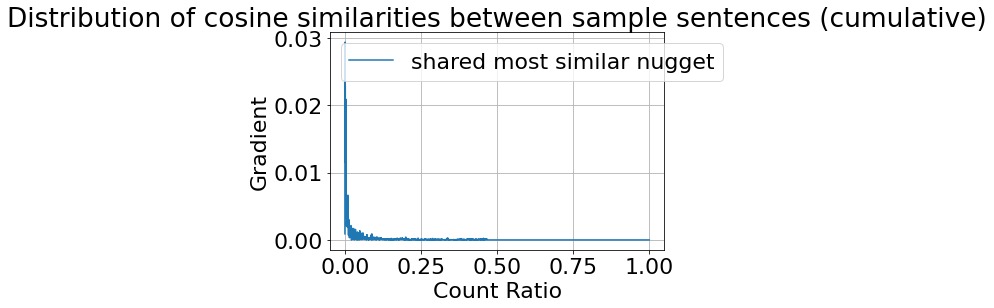

In [131]:
sum_gen.plot_sim_nugget_distributions(same_nug_sims, dif_nug_sims)

## Generate Summaries

In [ ]:
def gen_score_df_path(tuner_dir, topic_id, X_col, corpus_name):
    fn = str(topic_id) + "_" + str(X_col) + "_" + str(corpus_name)
    fn += ".hdf"
    path = os.path.join(tuner_dir, fn)
    return path

def gen_ranked_df_path(tuner_dir, rank_method, topic_id, X_col, corpus_name):
    fn = str(rank_method) + "_" + str(topic_id) + "_" + str(X_col) + "_" + str(corpus_name)
    fn += ".hdf"
    path = os.path.join(tuner_dir, fn)
    return path

def gen_varname_path(tuner_dir, varname, rank_method, topic_id, X_col, corpus_name):
    fn = "ranked_idxs" + "_" + str(rank_method) + "_" + str(topic_id) + "_" + str(X_col) + str(corpus_name)
    fn += ".pickle"
    path = os.path.join(tuner_dir, fn)
    return path

In [ ]:
class SummaryGenerator:
    def __init__(self, model_path_handler, proj_repo='/nfs/proj-repo/AAARG-dissertation'):
        self.model_path_handler = self.model_path_handler
        self.path_ret = PathRetriever(proj_repo)
        self.proj_repo = proj_repo
        self.rank_methods = ['k', 'k_non_redund']
        
    def generate_ranked_df(self, rank_method, model, tuner_dir, corpus_name, nested_dir, topic_id, k=10000,
                         X_col='embedding', batch_size=256, redundancy_score=None, verbose=verbose,
                          force_reload=False):
        
        # create/load predicted scores
        score_df_path = gen_score_df_path(tuner_dir, topic_id, X_col, corpus_name)
        score_df = None
        if os.path.exists(score_df_path):  # load
            score_df = read_df_file_type(score_df_path, verbose=verbose)
        else:  
            # create df of predicted scores
            emb_paths = self.path_ret.get_embedding_paths(corpus_name, nested_dir, topic_ids=topic_id, 
                                                      return_dir_path=False)
            emb_paths = list(emb_paths['path'])
            score_df = self.get_prediction_scores(model, emb_paths, X_col=X_col, batch_size=batch_size,
                                                 sort_scores=True)
            # save df
            score_df = save_df_file_type(score_df_path, verbose=verbose)
        
        # get ranked df
        ranked_df = None
        ranked_df_path = gen_ranked_df_path(tuner_dir, rank_method, topic_id, X_col, corpus_name)
        if not os.path.exists(ranked_df_path) or force_reload:
            # load new ranked_df with selected method
            ranked_idxs = None
            if rank_method == "k":
                ranked_df = self.retrieve_top_k_sentences(score_df, k, is_sorted=True)
            elif rank_method == "k_non_redund":
                ranked_df, ranked_idxs = self.ret_top_k_non_redundant(score_df, 
                                                                    k, 
                                                                    redundancy_threshold, 
                                                                    X_col='embedding', 
                                                                    is_sorted=True,
                                                                    return_indexes=True)
            else:
                raise Exception(str(rank_method) + " is not a valid rank_method: " + str(self.rank_methods))
            # save ranked_idxs
            if ranked_idxs is not None:
                ranked_idxs_path = gen_varname_path(tuner_dir, "ranked_idxs", rank_method, topic_id, X_col,
                                                   corpus_name)
                with open(ranked_idxs_path, 'wb') as handle:
                    pickle.dump(ranked_idxs, handle, protocol=pickle.HIGHEST_PROTOCOL)
        else:
            ranked_df = read_df_file_type(ranked_df_path, verbose=verbose)
            
        return ranked_df
        
        
        
    def get_prediction_scores(self, model, emb_paths, X_col='embedding',
                             batch_size=256, sort_scores=True, add_X_col_to_df=True):
        """
        Return dataframe with columns:
            sentence: string of sentence
            score: predicted score from model
            relative_pos: relative_position of sentence in its article (sent_id)
            embedding (optional): embedding of sentence (determined by X_col parameter)
        """
        
        # predict scores for target embeddings to place into df
        score_df_dict = defaultdict(list)
        print("Predicting scores...")
        for emb_path in tqdm_notebook(emb_paths):
            emb_df = load_embeddings(emb_path, verbose=False)
            embs = list(embs[X_col])
            
            scores = predict_emb_list(model, emb_list, batch_size=batch_size)
            
            score_df_dict['sentence'].extend(list(emb_df['sentence']))
            score_df_dict['score'].extend(scores.tolist())
            score_df_dict['relative_pos'].extend(list(emb_df['sent_id']))  # relative position in article
            if add_X_col_to_df:
                score_df_dict['embedding'].extend(embs)
        
        # tie sentence <-> score together and access DataFrame functionality
        score_df = pd.DataFrame(score_df_dict)
        if sort_scores:
            score_df = score_df.sort_values(by="score", ascending=False)  # descending order
        return score_df
        
    def retrieve_top_k_sentences(self, score_df, k, is_sorted=True):
        """
        Retrieve top k scoring sentences from score_df
        """
        if not is_sorted:
            score_df = score_df.sort_values(by="score", ascending=False)
        
        top_k_df = score_df[0:k]
        
        return top_k_df
    
    def ret_top_k_non_redundant(self, score_df, k, redundancy_threshold, X_col='embedding', is_sorted=True,
                               return_indexes=True):
        """
        Retrieve top k sentences from df, not repeating redundant sentences
        """
        if not is_sorted:
            score_df = score_df.sort_values(by="score", ascending=False)
        
        top_k_rows = []
        top_k_row_idxs = None
        if return_indexes:
            top_k_row_idxs = []
        
        # iteratively find top k sentences where cosine similarity is under redundancy_threshold
        for index, row in score_df.iterrows():
            under_threshold = True
            row_emb = row['embedding']
            for k_row in top_k_rows:  # compare cosine similarity with each sentence so far
                k_emb = k_row['embedding']
                cos_sim = cosine_similarity(row_emb, k_emb)
                if cos_sim >= redundancy_threshold:
                    under_threshold = False
                    break  # break from nested loop
            if under_threshold:  # add when dissimilar enough
                top_k_rows.append(row)
                if return_indexes:
                    top_k_row_idxs.append(index)
            if len(top_k_rows) == k:
                break
        
        top_k_df = pd.DataFrame(top_k_rows)
#         top_k_df = self.order_by_article_position(top_k_df)
        return top_k_df
    
    def order_by_article_position(self, top_k_df):
        """Order sentences by relative article position"""
        top_k_df = top_k_df.sort_values(by="relative_pos", ascending=True)
        return top_k_df
    
    def 